In [1]:
import pandas as pd

import numpy as np
import cv2
import os
import time as t

import datetime
import pvlib
from pvlib.location import Location
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

import mysql.connector # lastes ned ved 'pip install mysql' i command promt
from load_snowdata import load_snowdata_apelsvoll
import sys

sys.path.append(r'C:\Users\heinenr\Documents\git_local\twin_tools\\')

from twin_tools import get_statistical_twin, remove_outliers, sort_split_dfs
from sklearn import metrics

import pickle

In [2]:
def get_cloud_map(frame, method='brd_ref'):
    """Takes an RGB-image (numpy-array) and transforms to a cloud map through a image algorithm and naive thresholding"""
        
    if method=='brd_ref':
        r_ref = np.mean(frame[:, :, 2]) # defining mean red value for polar converted image
        b_ref = np.mean(frame[:, :, 0]) # defining mean blue value for polar converted image

        cloud_map = np.subtract((frame[:, :, 0]-b_ref), (frame[:, :, 2]-r_ref)).astype(np.uint8)           

        cloud_map[cloud_map<(np.mean(cloud_map))]=0
        cloud_map[cloud_map>(np.mean(cloud_map))]=255
    else:
        frame=None
        print('Model not recognized. Valid models are brd_ref')
    return cloud_map

In [3]:
def corners_inside_sun(speed_ave, angle_ave, good_corners, cloud_map, location, prediction_horizon, resize_dim, frames_per_min=2):    
    inside = []


    predicted_point = np.zeros_like(good[-1])

    num_frames=prediction_horizon*frames_per_min #how many frames into the future to predict
    displacement_x = num_frames*speed_ave*np.cos(angle_ave)
    displacement_y = num_frames*speed_ave*np.sin(angle_ave)
    predicted_point[:,0], predicted_point[:,1] = (good_corners[-1][:,0] + displacement_x), (good_corners[-1][:,1] + displacement_y)

    prediction_time = time + pd.Timedelta(prediction_horizon, unit='min')

    #get the solar position in the location and times specified
    solpos = location.get_solarposition(prediction_time)
    rho = resize_dim/2

    # cylindrical
    r = rho*np.sin(np.radians(solpos['apparent_zenith']))
    azimuth = np.radians(solpos['azimuth']) + (9*np.pi/16) # camera is rotated approx 10 degs, so a correction factor of pi/16 is needed (specific for apelsvoll). pi/2 is added to rotate image so that 0 is north. 

    #fisheye distortion
    r_norm = r/rho

    r_dist_norm = 2*(r_norm + (1-np.sqrt(1 -r_norm**2))/2)/3 #must divide the normal fisheye formula by 1.5. Don't know why
    r_dist = r_dist_norm*rho

    # to cartesian (and adjusting to fit picture indices)
    x_dist=r_dist*np.cos(azimuth)+rho
    y_dist=rho-r_dist*np.sin(azimuth)

    points_inside = (predicted_point[:,0]>(x_dist[0]-20))&(predicted_point[:,0]<(x_dist[0]+20))&(predicted_point[:,1]>(y_dist[0]-20))&(predicted_point[:,1]<(y_dist[0]+20))
    points_inside_sum = points_inside.sum()
    pixels = good_corners[-1][points_inside]
    roi_sum = 0

    if len(pixels)>0:
        for pixel in pixels:
            roi = cloud_map[(int(pixel[0])-20):(int(pixel[0])+20), (int(pixel[1])-20):(int(pixel[1])+20)]
            roi_mean = np.mean(roi)
            roi_sum += roi_mean
            roi_ave = roi_sum/len(pixels)
    else:
        roi_ave=0           

    inside.append([time, points_inside_sum, roi_ave])
    columns = [[prediction_horizon], ['num_corners', 'ave_pixel_intensity']]


    inside_df = pd.DataFrame(inside)
    inside_df.index = inside_df.pop(0)
    inside_df.columns = pd.MultiIndex.from_product(columns, names=['time_ahead', 'predictions'])

    return inside_df, predicted_point, x_dist, y_dist

In [4]:
def get_clearsky_irr(times, location):
    
    # Run functions
    lin_turb = pvlib.clearsky.lookup_linke_turbidity(times,
                                                     location.latitude,
                                                     location.longitude)

    cSky = location.get_clearsky(times, model='ineichen',
                                linke_turbidity=lin_turb)
    solarpos = pvlib.solarposition.spa_python(times, location.latitude,
                                              location.longitude,
                                              altitude=location.altitude)

    extr_terr_irr = pvlib.irradiance.get_extra_radiation(times)
    AM = location.get_airmass(solar_position=solarpos)
    POA_total = pvlib.irradiance.get_total_irradiance(syst_angles['tilt'],
                                                      syst_angles['azimuth'],
                                                      solarpos['apparent_zenith'],
                                                      solarpos['azimuth'],
                                                      cSky.dni, cSky.ghi, cSky.dhi,
                                                      extr_terr_irr,
                                                      AM.airmass_absolute,
                                                      model='perez')

    POA_total.index = range(1,times.shape[0]+1)
    poa_trans = POA_total.transpose()
    poa_trans.columns = pd.MultiIndex.from_product([list(POA_total.index),['clear_sky_POA']], names=['time_ahead', 'predictions'])
    poa_trans_global = poa_trans.loc['poa_global']
    poa_trans_global.name = time
    poa_trans.index = [time, 'poa_direct','poa_diffuse', 'poa_sky_diffuse','poa_ground_diffuse'] # poa_global is given time-index so that it joins on the correect index with prediction_df
    return poa_trans, POA_total

In [5]:
directory = r"C:\Users\heinenr\OneDrive - Institutt for Energiteknikk\Prosjekt\Solar Farm\kamerabileter\Calibrate pixel intensity\all_days"
first_image_path = r'C:\Users\heinenr\OneDrive - Institutt for Energiteknikk\Prosjekt\Solar Farm\kamerabileter\Calibrate pixel intensity\all_days\20190621030000_11.jpg'
first = cv2.imread(first_image_path, 1)

resize_dim = 600
max_dim = max(first.shape)
scale = resize_dim/max_dim
old_frame = cv2.resize(first, None, fx=scale, fy=scale)

black = np.zeros_like(old_frame)
circle = cv2.circle(black, (int(black.shape[0]/2), int(black.shape[1]/2)), int(black.shape[0]/2)-25, color=(255,255,255), thickness=-1)
white_mask = (cv2.cvtColor(circle, cv2.COLOR_BGR2GRAY)/255).astype(np.uint8)

old_cloud_map = get_cloud_map(old_frame)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 10000,
                       qualityLevel = 0.05,
                       minDistance = 1,
                       blockSize = 15 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(10000,3))

# Take first frame and find corners in it

p_first = cv2.goodFeaturesToTrack(old_cloud_map, mask = white_mask, **feature_params)

# Create a mask image for drawing purposes

num_frames_integrated = 4
frames_per_min = 2

syst_angles = {'tilt': 46, 'azimuth': 173}
location = Location(60.7008333, 10.867777777777778, tz='Europe/Oslo',
                   altitude=273, name='Apelsvoll')
# found from latlong.net, Østre Toten målestasjon i

In [ ]:
all_predictions = pd.DataFrame()
evaluated_times = []

start = t.time()
for image in range(len(os.listdir(directory))):
    
    for root, dirs, files in os.walk(directory):
        filenames = []
        
        for name in files[image:image+num_frames_integrated]:
            filename = os.path.join(root, name)
            filenames.append(filename)
    
    if len(filenames)<num_frames_integrated:
        break
    
    else:
        p = []
        good = []
        speed = []
        angle = []
        
        f0=filenames[0]
        mask = np.zeros_like(old_frame)


        frame0 = cv2.imread(f0, 1)
        frame0 = cv2.resize(frame0, None, fx=scale, fy=scale)

        cloud_map0 = get_cloud_map(frame0)

        p.append(cv2.goodFeaturesToTrack(cloud_map0, mask = white_mask, **feature_params))

        if p[0] is None:
            p_placeholder, st0, err = cv2.calcOpticalFlowPyrLK(old_cloud_map, cloud_map0, p_first, None, **lk_params)
            p.append(p_placeholder)
            # Select good points
            good.append(np.ones_like(p_placeholder[st0==1]))
        else:
            p[0] = p[0].astype(np.float32)

            # calculate optical flow
            p_placeholder, st0, err = cv2.calcOpticalFlowPyrLK(old_cloud_map, cloud_map0, p[0], None, **lk_params)
            p.append(p_placeholder)
            good.append(p[0][st0==1])
        
        good.append(p[1][st0==1])
        
        speed.append(np.sqrt((good[1][:,1]-good[0][:,1])**2+(good[1][:,0]-good[0][:,0])**2))
        angle.append(np.arctan((good[1][:,1]-good[0][:,1])/(good[1][:,0]-good[0][:,0])))
            
        old_cloud_map = cloud_map0.copy()
        
        for frame_num in range(2,(len(filenames))):
            
            file=filenames[frame_num]

            frame = cv2.imread(file, 1)
            frame = cv2.resize(frame, None, fx=scale, fy=scale)

            cloud_map = get_cloud_map(frame)

            # calculate optical flow
            p_placeholder, st, err = cv2.calcOpticalFlowPyrLK(cloud_map0, cloud_map, p[frame_num-1], None, **lk_params)
            p.append(p_placeholder)
            good.append(p[frame_num][st0==1])
            
            speed.append(np.sqrt((good[frame_num][:,1]-good[frame_num-1][:,1])**2+(good[frame_num][:,0]-good[frame_num-1][:,0])**2))
            angle.append(np.arctan((good[frame_num][:,1]-good[frame_num-1][:,1])/(good[frame_num][:,0]-good[frame_num-1][:,0])))
            
            cloud_map0 = cloud_map.copy()
            
        speed_ave = np.zeros_like(speed[0])
        angle_ave = np.zeros_like(angle[0])
        
        for i in range(len(speed)):
            speed_sum = np.add(speed_ave,speed[i])
            angle_sum = np.add(angle_ave,angle[i])
        
        speed_ave = speed_sum/len(speed)
        angle_ave = angle_sum/len(speed)
        
        time = pd.to_datetime(file[-21:-7])
        evaluated_times.append(time)
        prediction_df = pd.DataFrame()
        for prediction_horizon in range(1,31):
            
            inside_df, predicted_point, x_dist, y_dist = corners_inside_sun(speed_ave, angle_ave, good, cloud_map, location, prediction_horizon, resize_dim, frames_per_min=2)

            prediction_df = pd.concat([prediction_df, inside_df], axis=1)
        
        times = pd.date_range(time+pd.Timedelta(1,unit='min'), periods=30, freq='T')

        poa_trans, POA_total = get_clearsky_irr(times, location)
        prediction_df = prediction_df.join(poa_trans).sort_index(axis=1)
        # draw the tracks
        try:
            for n,(new,predicted) in enumerate(zip(good[-1],predicted_point)):

                a,b = new.ravel()
                c,d = predicted.ravel()
                move_im = cv2.line(mask, (c,d),(a,b), color[n].tolist(), 2)
        except:
            continue
            
        a,b = int(x_dist), int(y_dist)
        sun = cv2.circle(frame, (a,b), 20, (0,0,0), -1)
        
        img = cv2.addWeighted(frame,1,mask,0.3,0)
        img = cv2.multiply(img, (circle/255).astype(np.uint8), None, 1)

        cv2.imshow('frame',img)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        # Now update the previous frame and previous points
        all_predictions = pd.concat([all_predictions, prediction_df], axis=0)
        p[0] = good[1].reshape(-1,1,2)
    
    if (time.minute == 0) and (time.second == 0):
        stop = t.time()
        duration=stop-start
        print('Evaluating images from:',str(time)[:-6])
        print('The previous hour took',duration/60,'mins to analyze')
        start = t.time()
cv2.destroyAllWindows()

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_laun

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide


Evaluating images from: 2019-06-21 04
The previous hour took 1.300562898317973 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 05
The previous hour took 1.3203792572021484 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 06
The previous hour took 1.3455507715543111 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 07
The previous hour took 1.3197898864746094 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 08
The previous hour took 1.354852561155955 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 09
The previous hour took 1.4192501425743103 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


Evaluating images from: 2019-06-21 10
The previous hour took 1.4149578015009563 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 11
The previous hour took 1.3419250925381978 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 12
The previous hour took 1.4909175554911296 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

Evaluating images from: 2019-06-21 13
The previous hour took 1.5491815606753032 mins to analyze


C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\heinenr\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_lau

In [6]:
frame0 = cv2.imread(file, 1)
frame0 = cv2.resize(frame0, None, fx=scale, fy=scale)

plt.imshow(cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cloud_map)
plt.show()

NameError: name 'file' is not defined

In [7]:
cloud_number_sum = all_predictions.xs('num_corners', level='predictions', axis=1)*all_predictions.xs('ave_pixel_intensity', level='predictions', axis=1)
normalization_factor = np.array([52702.95375, 51618.52668103, 50534.09961207, 49449.6725431,
       48365.24547414, 47280.81840517, 46196.39133621, 45111.96426724,
       44027.53719828, 42943.11012931, 41858.68306034, 40774.25599138,
       39689.82892241, 38605.40185345, 37520.97478448, 36436.54771552,
       35352.12064655, 34267.69357759, 33183.26650862, 32098.83943966,
       31014.41237069, 29929.98530172, 28845.55823276, 27761.13116379,
       26676.70409483, 25592.27702586, 24507.8499569, 23423.42288793,
       22338.99581897, 21254.56875])
cloud_number_norm = 1-(cloud_number_sum/normalization_factor)
cloud_number_norm.columns = pd.MultiIndex.from_product([list(cloud_number_norm.columns), ['weighted_cloud_number']], names=['time_ahead', 'predictions'])
all_predictions = all_predictions.join(cloud_number_norm).sort_index(axis=1)

predicted_irr = (all_predictions.xs('weighted_cloud_number', level='predictions', axis=1))*all_predictions.xs('clear_sky_POA', level='predictions', axis=1)
predicted_irr.columns = pd.MultiIndex.from_product([list(predicted_irr.columns), ['predicted_irradiance']], names=['time_ahead', 'predictions'])
all_predictions = all_predictions.join(predicted_irr).sort_index(axis=1)
all_predictions.index.name = 'date_time'
all_predictions.head()

time_ahead                           1                             \
predictions         ave_pixel_intensity clear_sky_POA num_corners   
date_time                                                           
2019-06-21 03:01:30                 0.0     12.828376           0   
2019-06-21 03:02:00                 0.0     13.006976           0   
2019-06-21 03:02:30                 0.0     13.186053           0   
2019-06-21 03:03:00                 0.0     13.365589           0   
2019-06-21 03:03:30                 0.0     13.545566           0   

time_ahead                                                      \
predictions         predicted_irradiance weighted_cloud_number   
date_time                                                        
2019-06-21 03:01:30            12.828376                   1.0   
2019-06-21 03:02:00            13.006976                   1.0   
2019-06-21 03:02:30            13.186053                   1.0   
2019-06-21 03:03:00            13.365589                   1.0   
2019-06-21 03:03:30            13.545566                   1.0   

time_ahead                           2                             \
predictions         ave_pixel_intensity clear_sky_POA num_corners   
date_time                                                           
2019-06-21 03:01:30                 0.0     13.186053           0   
2019-06-21 03:02:00                 0.0     13.365589           0   
2019-06-21 03:02:30                 0.0     13.545566           0   
2019-06-21 03:03:00                 0.0     13.725967           0   
2019-06-21 03:03:30                 0.0     13.906775           0   

time_ahead                                                      ...  \
predictions         predicted_irradiance weighted_cloud_number  ...   
date_time                                                       ...   
2019-06-21 03:01:30            13.186053                   1.0  ...   
2019-06-21 03:02:00            13.365589                   1.0  ...   
2019-06-21 03:02:30            13.545566                   1.0  ...   
2019-06-21 03:03:00            13.725967                   1.0  ...   
2019-06-21 03:03:30            13.906775                   1.0  ...   

time_ahead                           29                            \
predictions         ave_pixel_intensity clear_sky_POA num_corners   
date_time                                                           
2019-06-21 03:01:30                 0.0     23.353195           0   
2019-06-21 03:02:00                 0.0     23.541726           0   
2019-06-21 03:02:30                 0.0     23.730037           0   
2019-06-21 03:03:00                 0.0     23.918120           0   
2019-06-21 03:03:30                 0.0     24.105967           0   

time_ahead                                                      \
predictions         predicted_irradiance weighted_cloud_number   
date_time                                                        
2019-06-21 03:01:30            23.353195                   1.0   
2019-06-21 03:02:00            23.541726                   1.0   
2019-06-21 03:02:30            23.730037                   1.0   
2019-06-21 03:03:00            23.918120                   1.0   
2019-06-21 03:03:30            24.105967                   1.0   

time_ahead                           30                            \
predictions         ave_pixel_intensity clear_sky_POA num_corners   
date_time                                                           
2019-06-21 03:01:30                 0.0     23.730037           0   
2019-06-21 03:02:00                 0.0     23.918120           0   
2019-06-21 03:02:30                 0.0     24.105967           0   
2019-06-21 03:03:00                 0.0     24.293572           0   
2019-06-21 03:03:30                 0.0     24.480927           0   

time_ahead                                                      
predictions         predicted_irradiance weighted_cloud_number  
date_time                      

In [2]:
_user='ifePVsystem'      # brukernavn
_password='Sol1Sinnet'   # passord
_host='128.39.229.38'    # evt. kj-sol-01, dette er adressen der serveren bor, og kan bare nåes på IFEs internnett (kabel eller VPN)
_database='pvs'          # navnet på databasen vår. En host kan ha flere databaser (som en blokk kan ha flere leiligheter)

In [3]:
query = '''SELECT date_time, irradiance_in_plane, irradiance_horizontal, ambient_temperature, panel_t1, panel_t2, panel_t3, panel_t4
            FROM temp_data
            WHERE id_site = 4
            AND (date_time BETWEEN '{0}' AND '{1}') 
            ORDER by date_time'''.format(evaluated_times[0], evaluated_times[-1]+pd.Timedelta(30, unit='T'))

NameError: name 'evaluated_times' is not defined

In [10]:
connection = mysql.connector.connect(user=_user, password=_password, host=_host, database=_database)
temp_data = pd.read_sql(query, con=connection)
connection.close()

In [11]:
query = '''SELECT date_time, wind_min, wind_max, wind_mid  
            FROM wind_data
            WHERE id_site = 4
            AND (date_time BETWEEN '{0}' AND '{1}') 
            ORDER by date_time'''.format(evaluated_times[0], evaluated_times[-1]+pd.Timedelta(30, unit='T'))

In [12]:
connection = mysql.connector.connect(user=_user, password=_password, host=_host, database=_database)
wind_data = pd.read_sql(query, con=connection)
connection.close()

In [13]:
query = '''SELECT date_time, ac_power 
            FROM inverter_data
            WHERE id_site = 4
            AND (date_time BETWEEN '{0}' AND '{1}') 
            ORDER by date_time'''.format(evaluated_times[0], evaluated_times[-1]+pd.Timedelta(30, unit='T'))

In [14]:
connection = mysql.connector.connect(user=_user, password=_password, host=_host, database=_database)
inverter_data = pd.read_sql(query, con=connection)
connection.close()

In [15]:
df_inverter = inverter_data.merge(temp_data).merge(wind_data)
df_inverter.index = df_inverter.date_time
df_inverter.drop('date_time', axis=1, inplace=True)
df_inverter.head()

ac_power  irradiance_in_plane  irradiance_horizontal  \
date_time                                                                   
2019-06-21 03:02:00       0.0                 3.60                    4.3   
2019-06-21 03:03:00       0.0                 3.64                    4.3   
2019-06-21 03:04:00       0.0                 3.89                    4.8   
2019-06-21 03:05:00       0.0                 4.17                    5.1   
2019-06-21 03:06:00       0.0                 4.30                    5.1   

                     ambient_temperature  panel_t1  panel_t2  panel_t3  \
date_time                                                                
2019-06-21 03:02:00                12.67     10.16     10.05     10.17   
2019-06-21 03:03:00                12.65     10.18     10.07     10.20   
2019-06-21 03:04:00                12.56     10.13     10.03     10.18   
2019-06-21 03:05:00                12.51     10.10     10.01     10.16   
2019-06-21 03:06:00                12.50     10.11     10.02     10.17   

                     panel_t4  wind_min  wind_max  wind_mid  
date_time                                                    
2019-06-21 03:02:00     10.23      2.65      3.29     2.971  
2019-06-21 03:03:00     10.24      1.51      3.13     2.310  
2019-06-21 03:04:00     10.22      1.31      2.74     2.057  
2019-06-21 03:05:00     10.19      2.07      3.50     2.752  
2019-06-21 03:06:00     10.20      1.54      3.85     2.439

C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.3 seconds to finish.


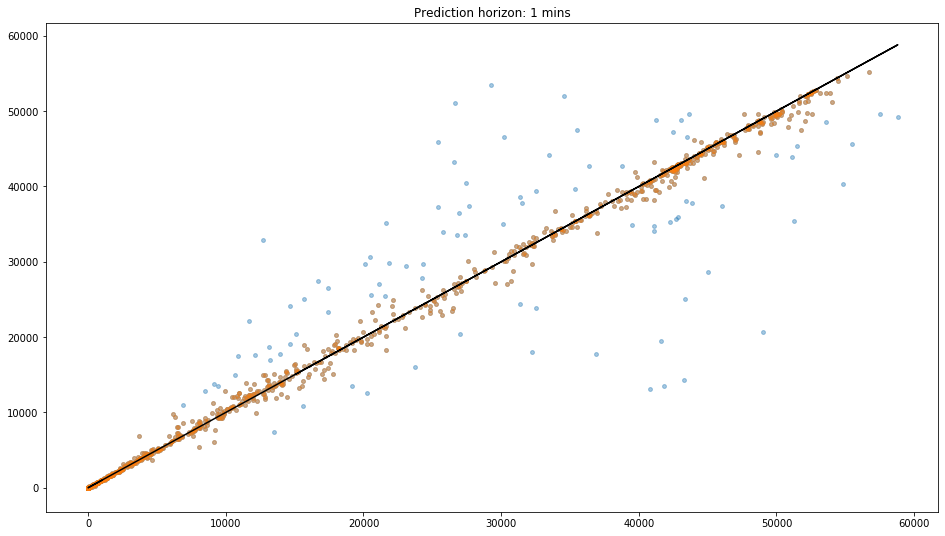

No handles with labels found to put in legend.


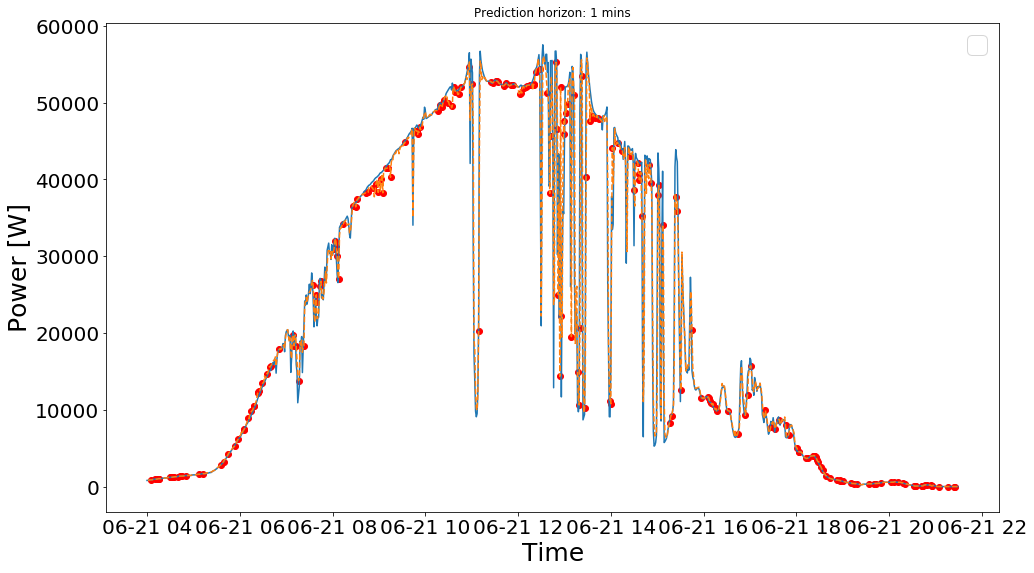

Mean Absolute Error: 1200.351751736925
R2 score: 0.9649973334824326
Mean Squared Error: 11853867.04429239
Root Mean Squared Error: 3442.9445311088575
Normalized RMSE: 0.08285656224940438
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.39 seconds to finish.


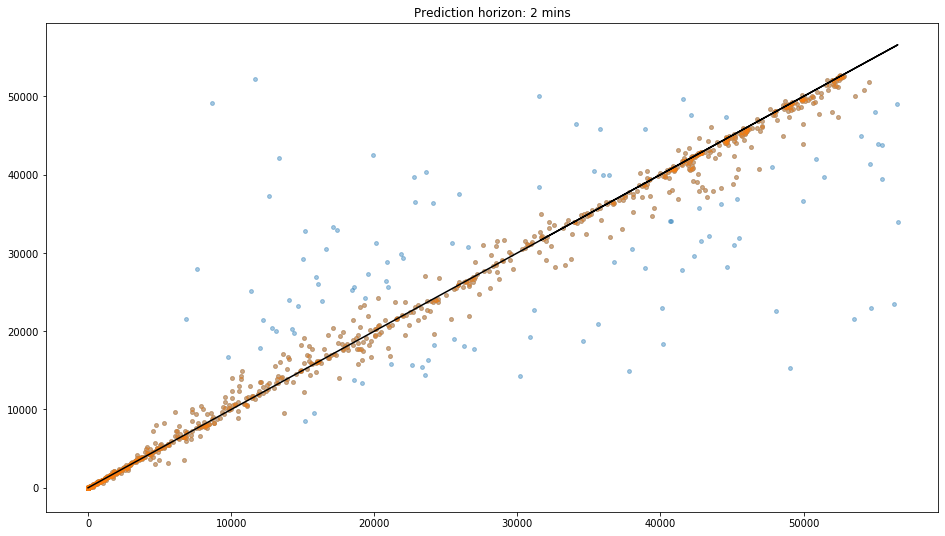

No handles with labels found to put in legend.


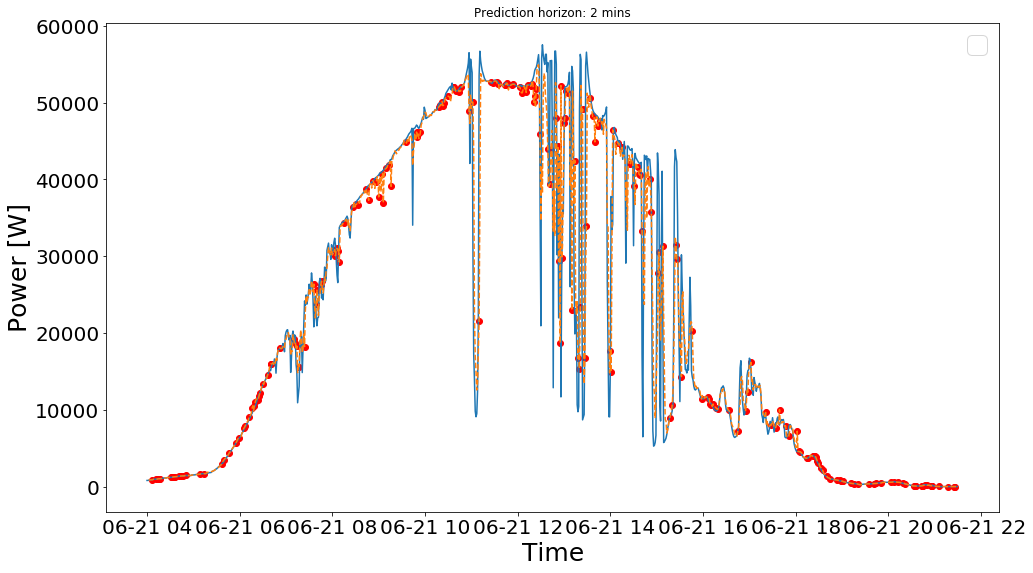

Mean Absolute Error: 1743.7704561500743
R2 score: 0.9356935750186924
Mean Squared Error: 21816798.70097296
Root Mean Squared Error: 4670.8456087707455
Normalized RMSE: 0.11305392162358896
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


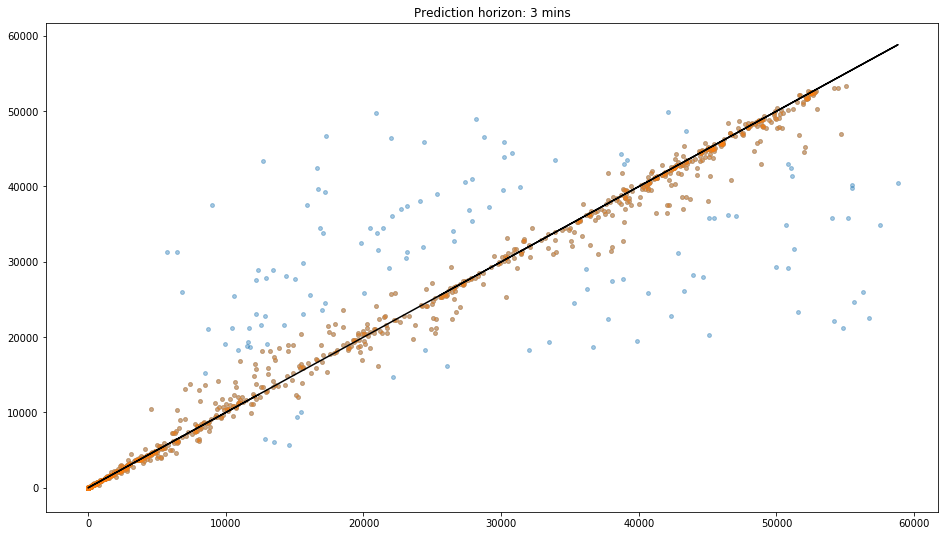

No handles with labels found to put in legend.


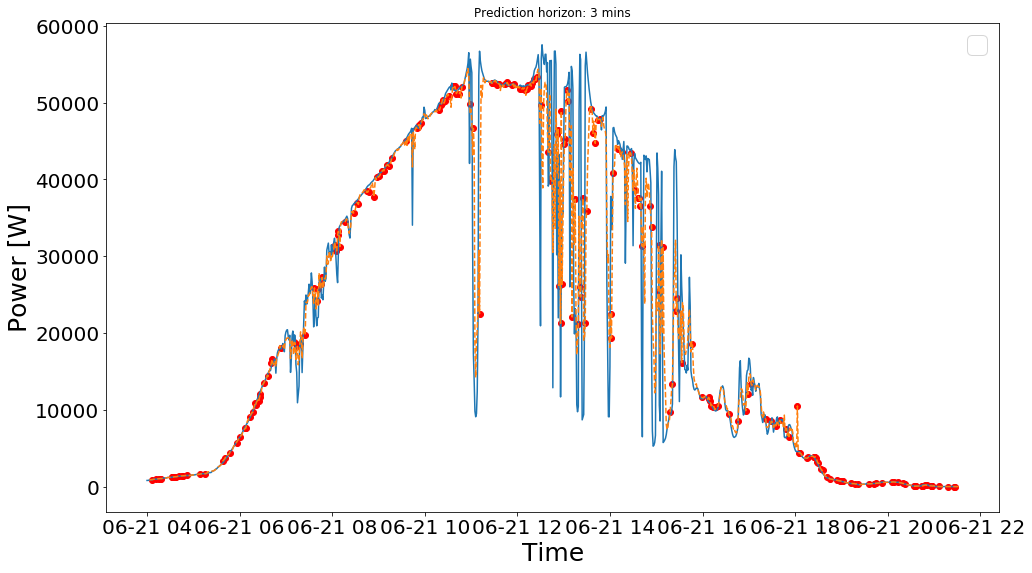

Mean Absolute Error: 2243.378997658424
R2 score: 0.9088293872910748
Mean Squared Error: 30908151.028457727
Root Mean Squared Error: 5559.509962978547
Normalized RMSE: 0.13538646899908793
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


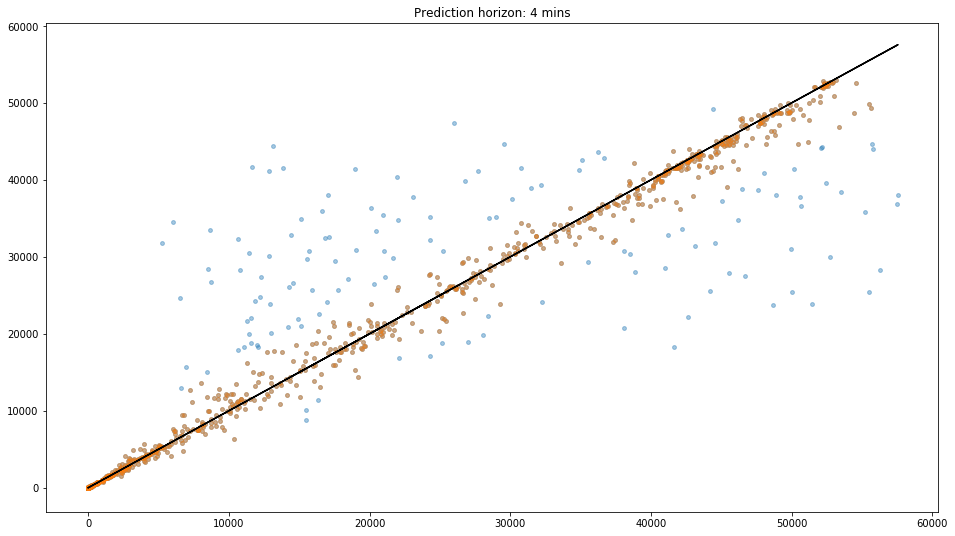

No handles with labels found to put in legend.


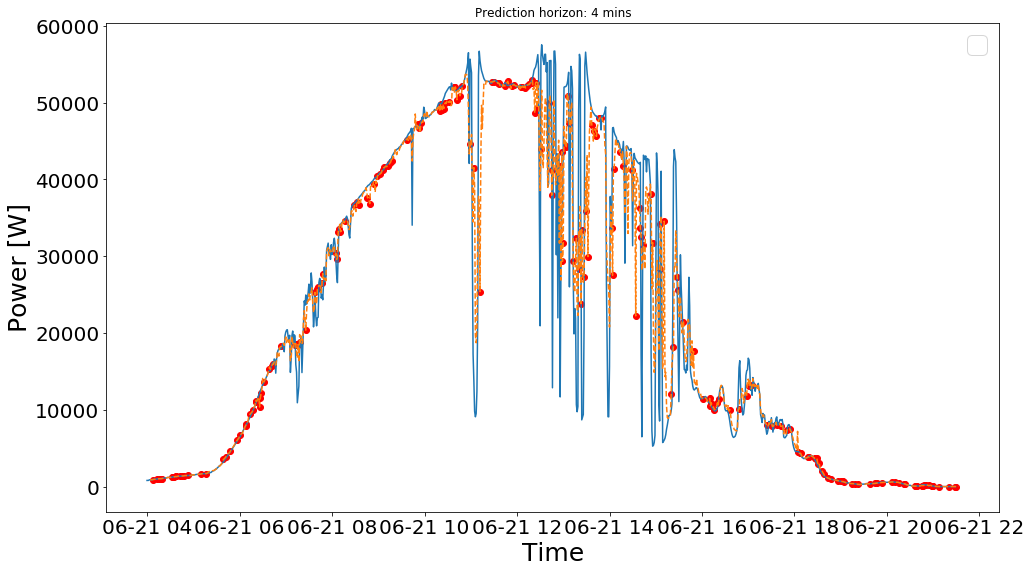

Mean Absolute Error: 2197.6122939633547
R2 score: 0.9172202424658495
Mean Squared Error: 27711344.26173984
Root Mean Squared Error: 5264.156557487613
Normalized RMSE: 0.12876675734263288
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.34 seconds to finish.


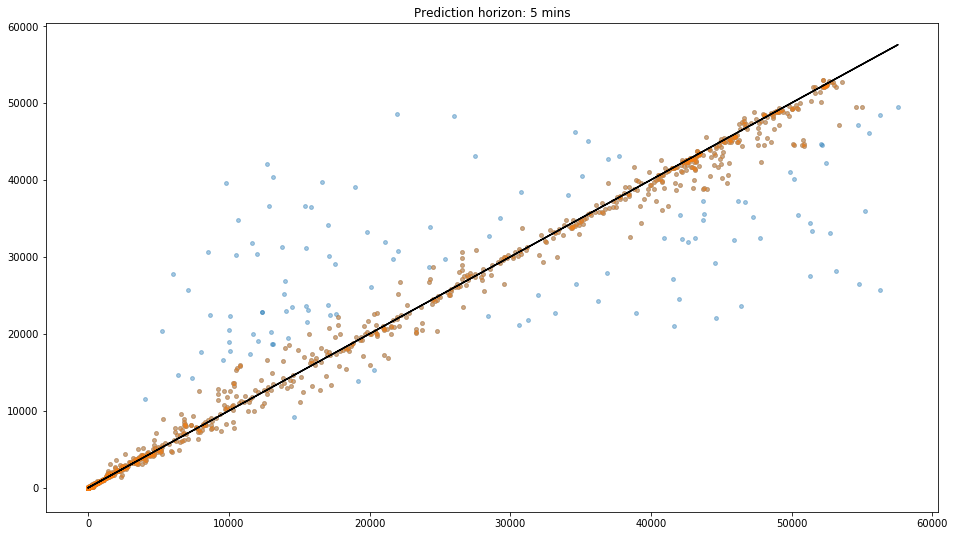

No handles with labels found to put in legend.


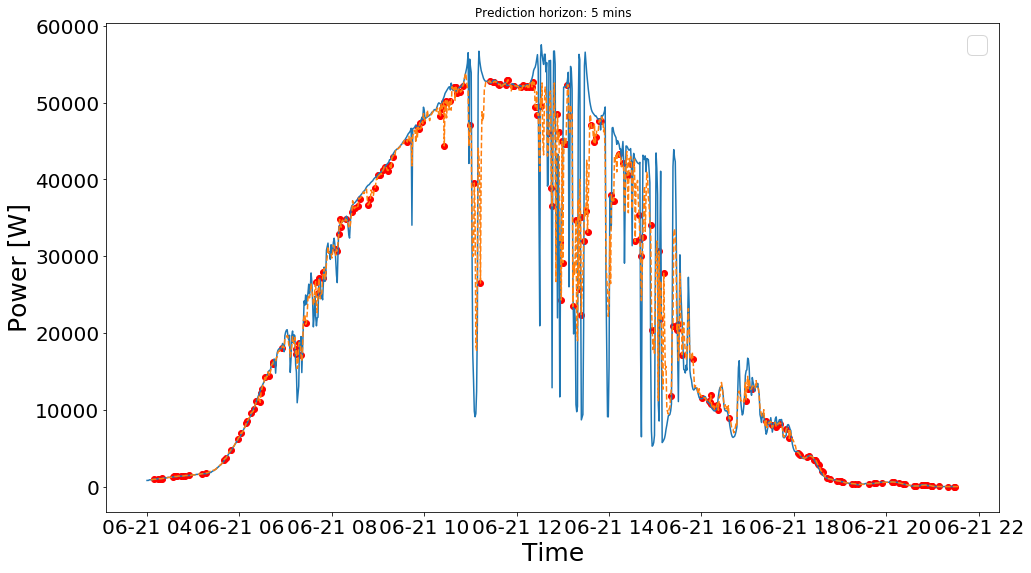

Mean Absolute Error: 2017.1281150443847
R2 score: 0.93013813233346
Mean Squared Error: 23892969.844500426
Root Mean Squared Error: 4888.043560004394
Normalized RMSE: 0.11752966106758861
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


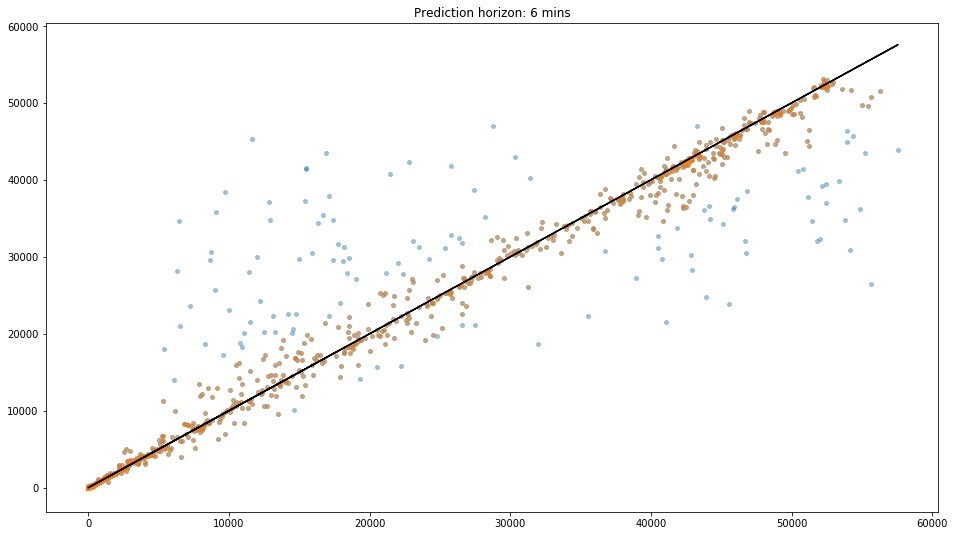

No handles with labels found to put in legend.


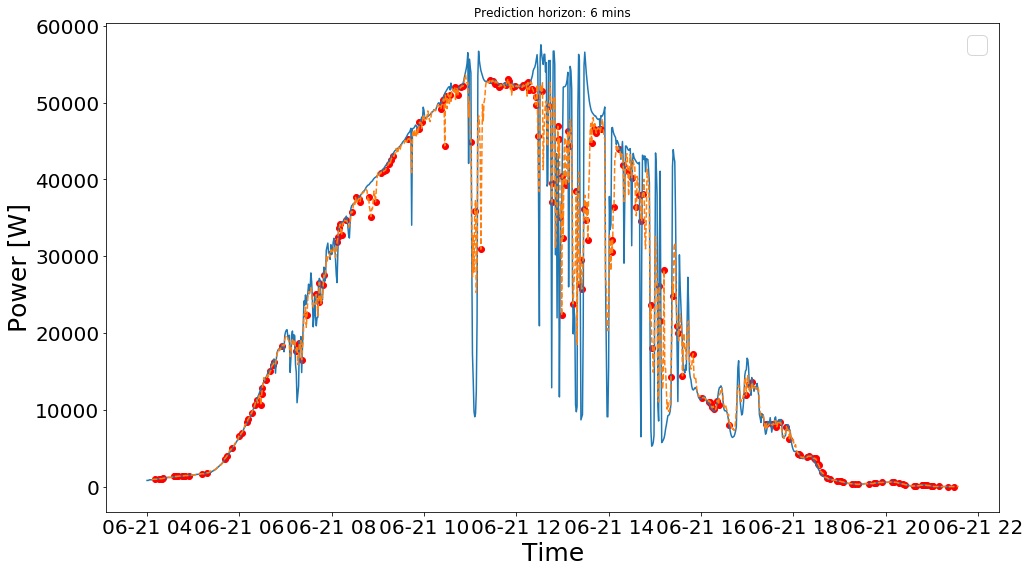

Mean Absolute Error: 2112.847725187034
R2 score: 0.9256551882534061
Mean Squared Error: 25270423.305503305
Root Mean Squared Error: 5026.969594646789
Normalized RMSE: 0.12077558225010544
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.34 seconds to finish.


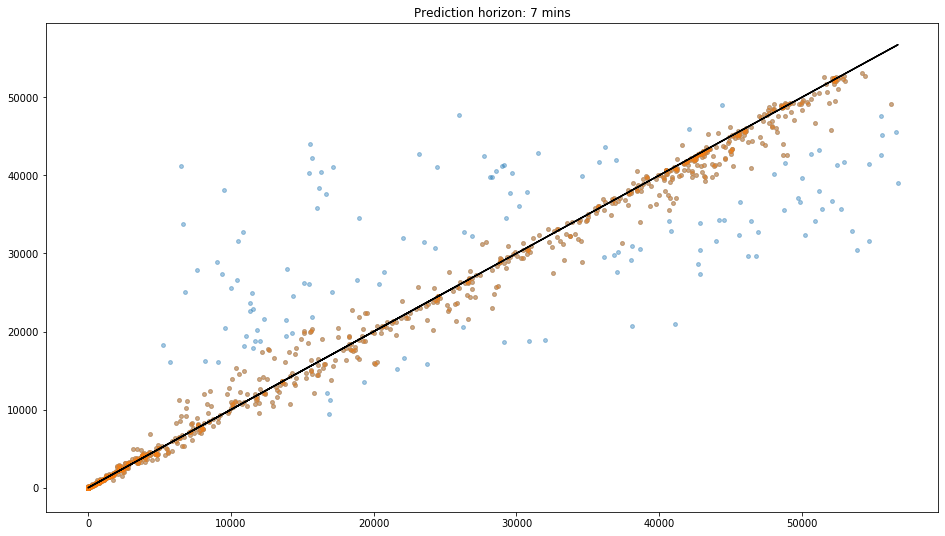

No handles with labels found to put in legend.


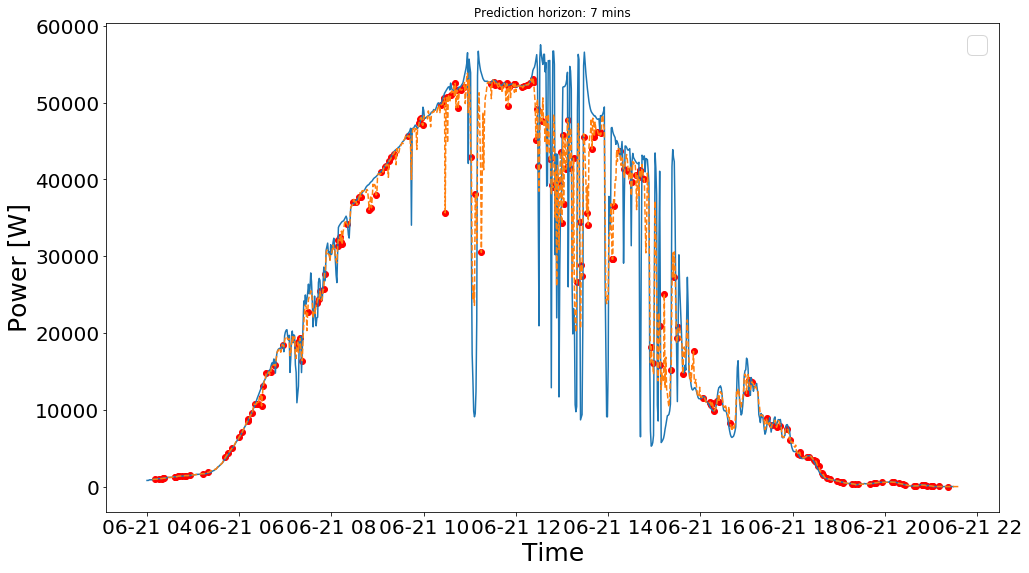

Mean Absolute Error: 2200.2445561879017
R2 score: 0.9248970705193654
Mean Squared Error: 25394917.90236543
Root Mean Squared Error: 5039.337049887161
Normalized RMSE: 0.1223837232007447
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


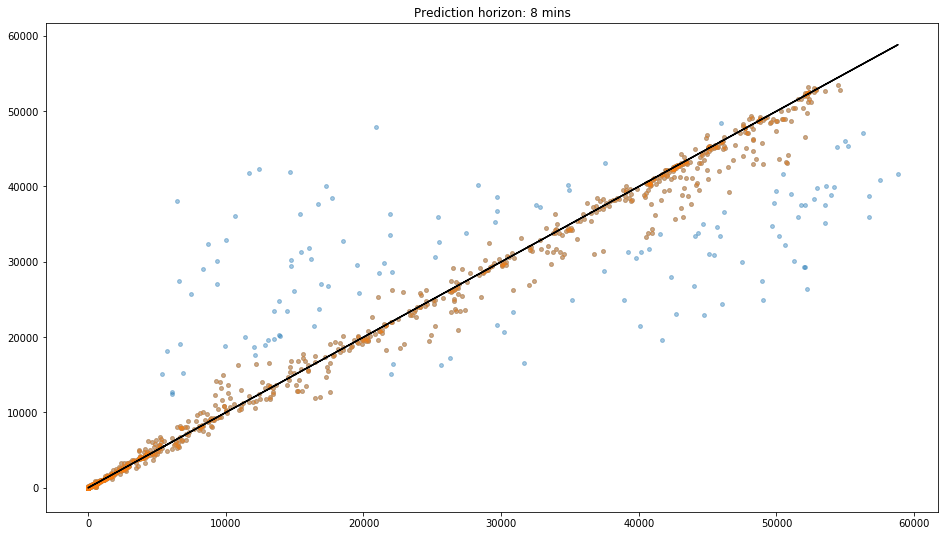

No handles with labels found to put in legend.


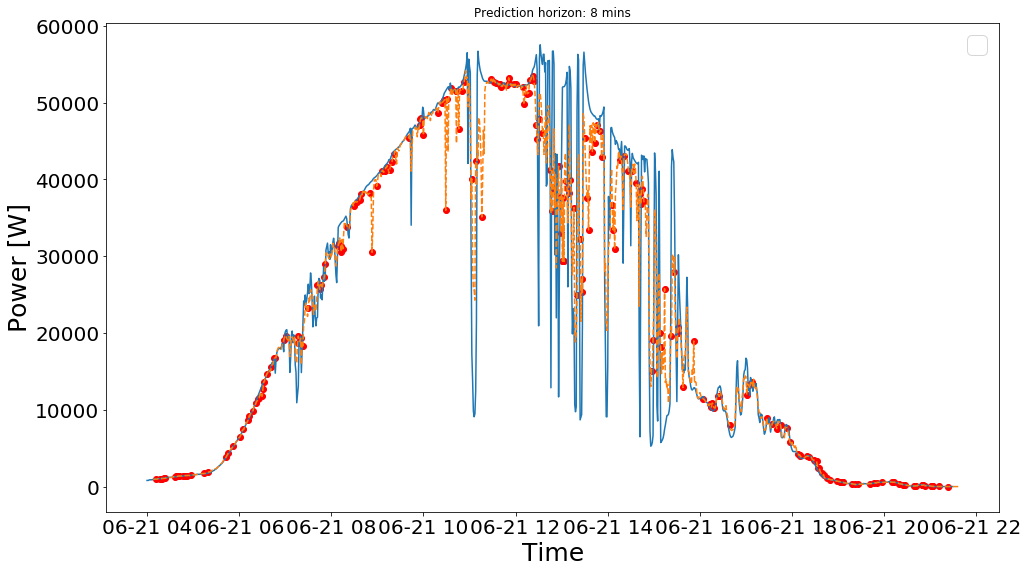

Mean Absolute Error: 2267.072738524302
R2 score: 0.9182670005902435
Mean Squared Error: 28435570.21380946
Root Mean Squared Error: 5332.501309311556
Normalized RMSE: 0.12848740660628125
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.37 seconds to finish.


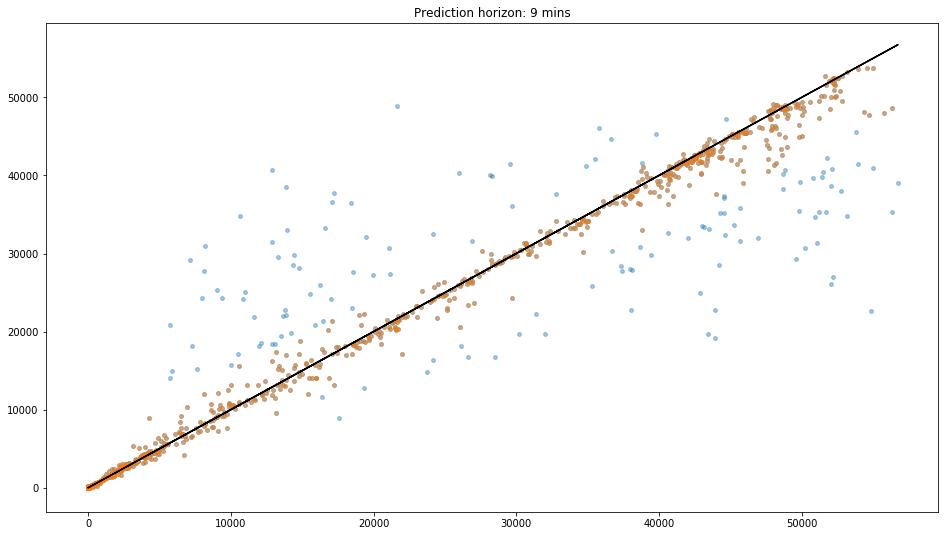

No handles with labels found to put in legend.


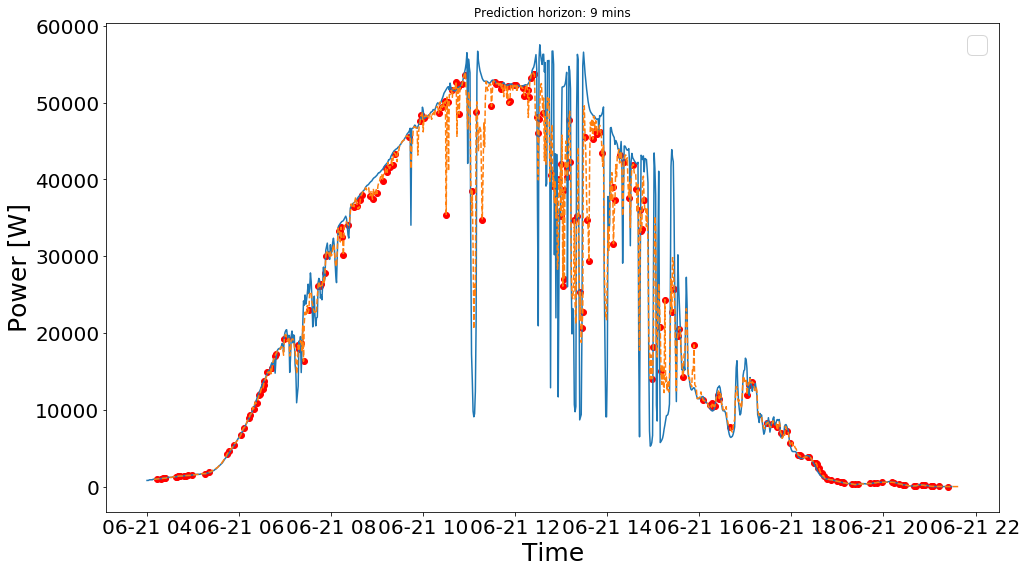

Mean Absolute Error: 2093.289185139202
R2 score: 0.9313376362986145
Mean Squared Error: 24351386.525534634
Root Mean Squared Error: 4934.712405554616
Normalized RMSE: 0.1174998667913075
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.37 seconds to finish.


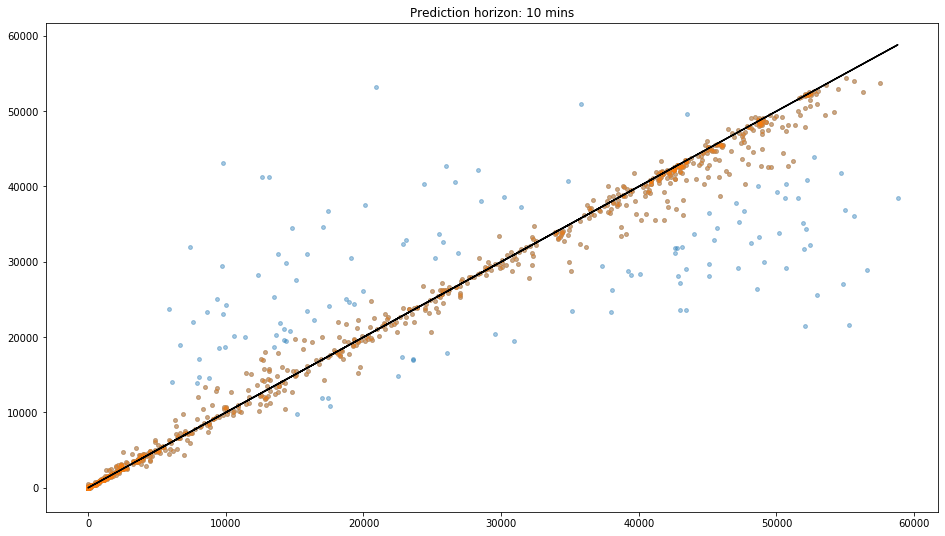

No handles with labels found to put in legend.


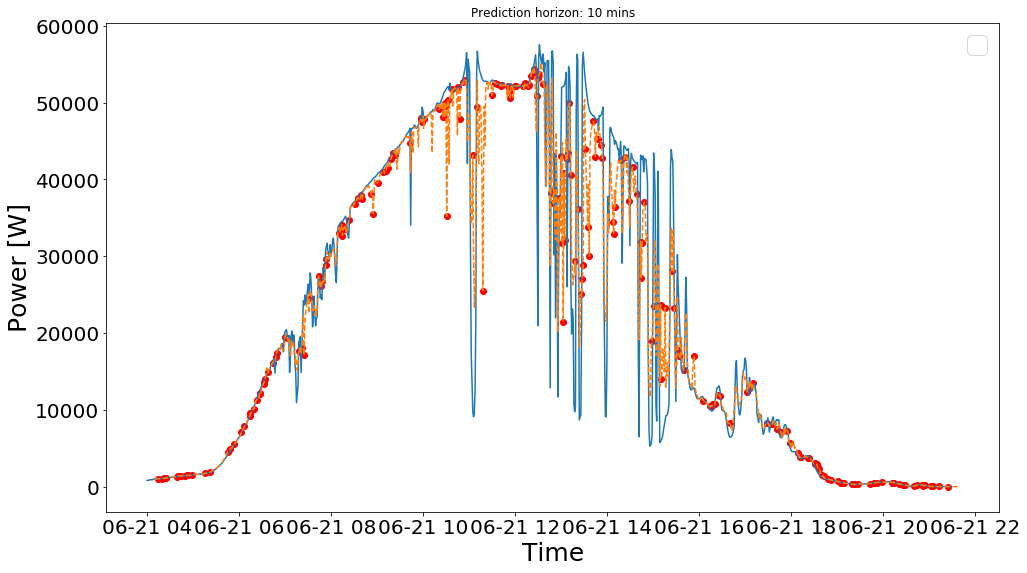

Mean Absolute Error: 2192.6817044705144
R2 score: 0.922427896219342
Mean Squared Error: 27396053.73287208
Root Mean Squared Error: 5234.123969956394
Normalized RMSE: 0.12458165855714325
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.42 seconds to finish.


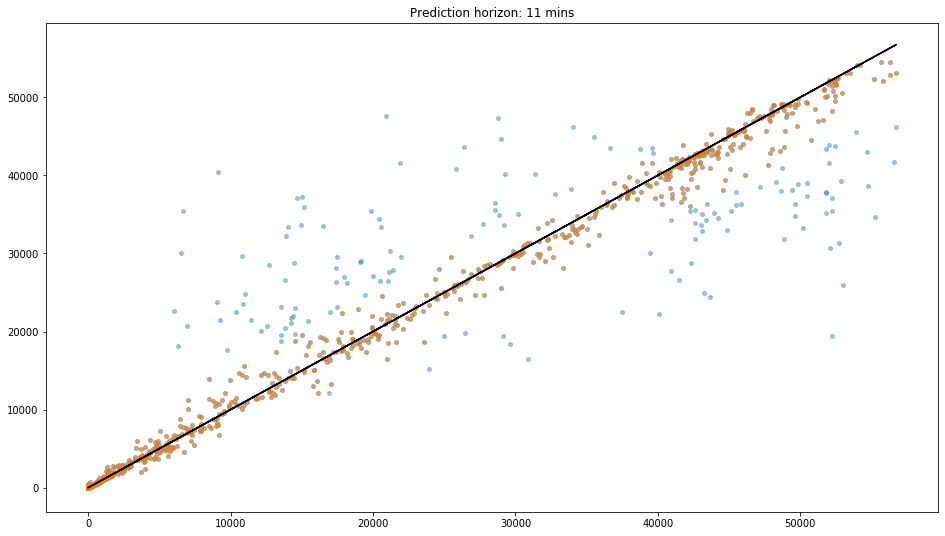

No handles with labels found to put in legend.


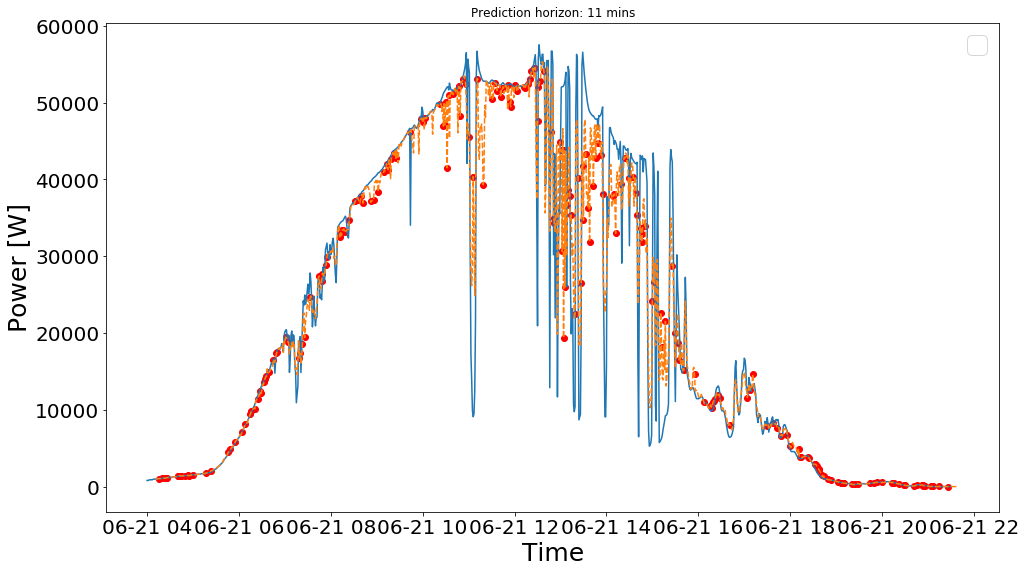

Mean Absolute Error: 2210.9898470718686
R2 score: 0.9293969009031584
Mean Squared Error: 24687443.902491115
Root Mean Squared Error: 4968.646083440751
Normalized RMSE: 0.11879588775422316
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


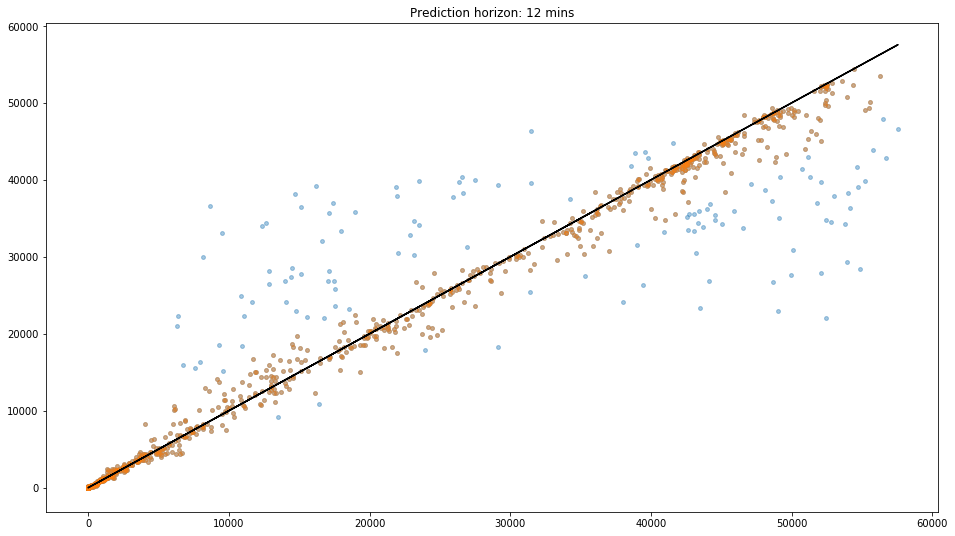

No handles with labels found to put in legend.


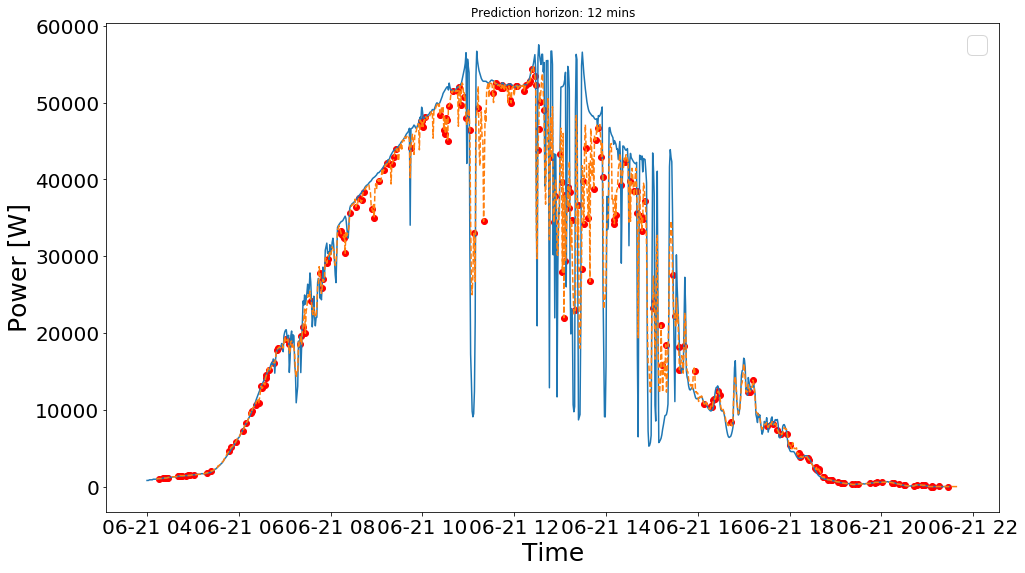

Mean Absolute Error: 2136.302261069749
R2 score: 0.9316829965744974
Mean Squared Error: 24098462.439628378
Root Mean Squared Error: 4909.018480269592
Normalized RMSE: 0.1175839001987252
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


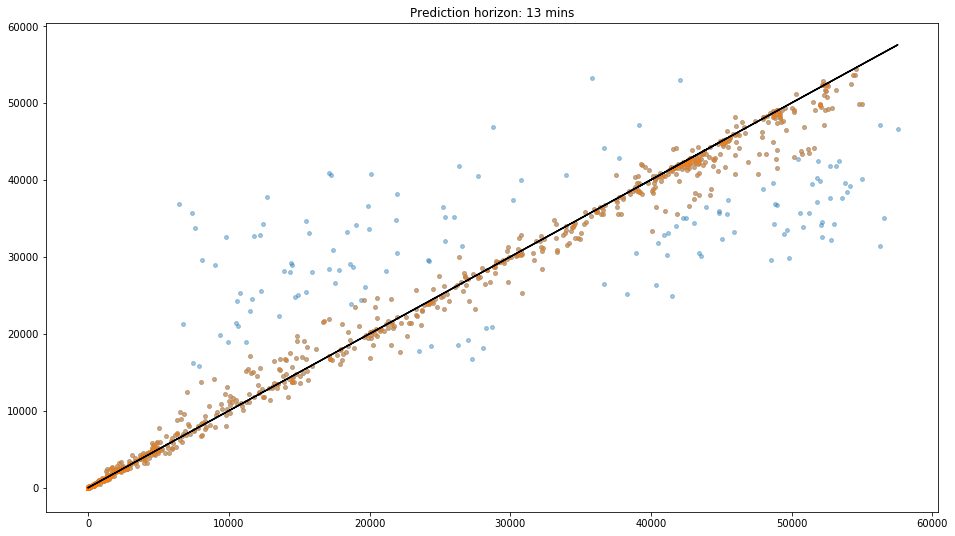

No handles with labels found to put in legend.


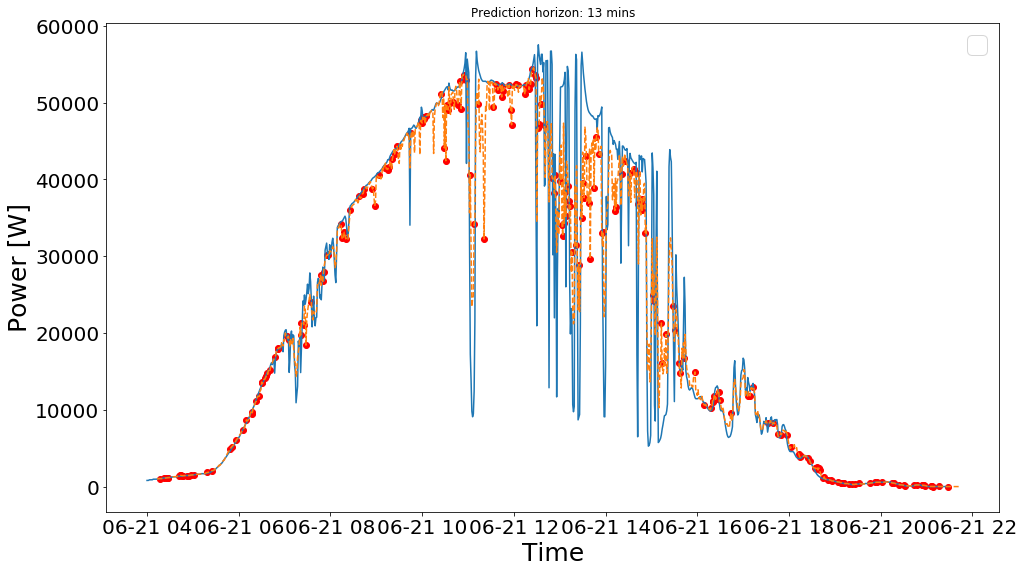

Mean Absolute Error: 2371.8542591172527
R2 score: 0.9222407116304456
Mean Squared Error: 27187550.30655282
Root Mean Squared Error: 5214.168227680501
Normalized RMSE: 0.1251752908318396
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.41 seconds to finish.


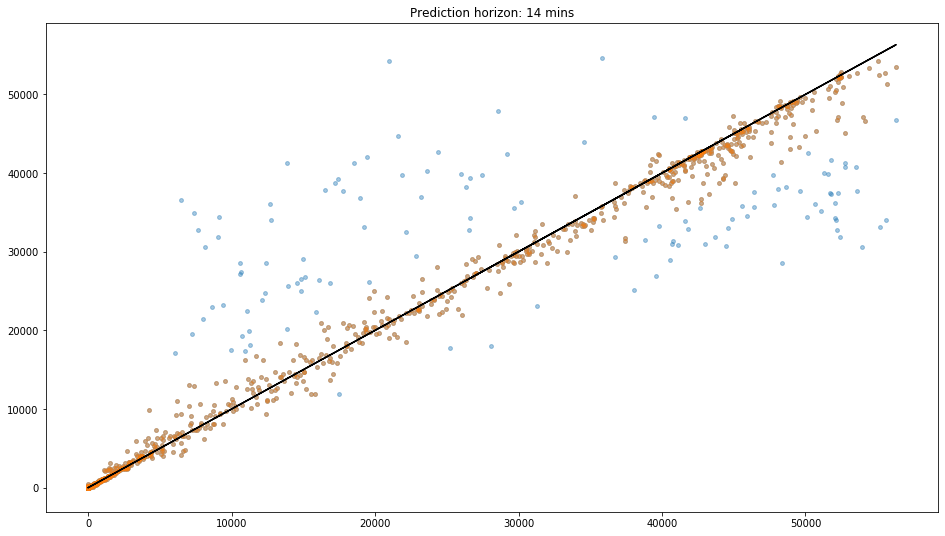

No handles with labels found to put in legend.


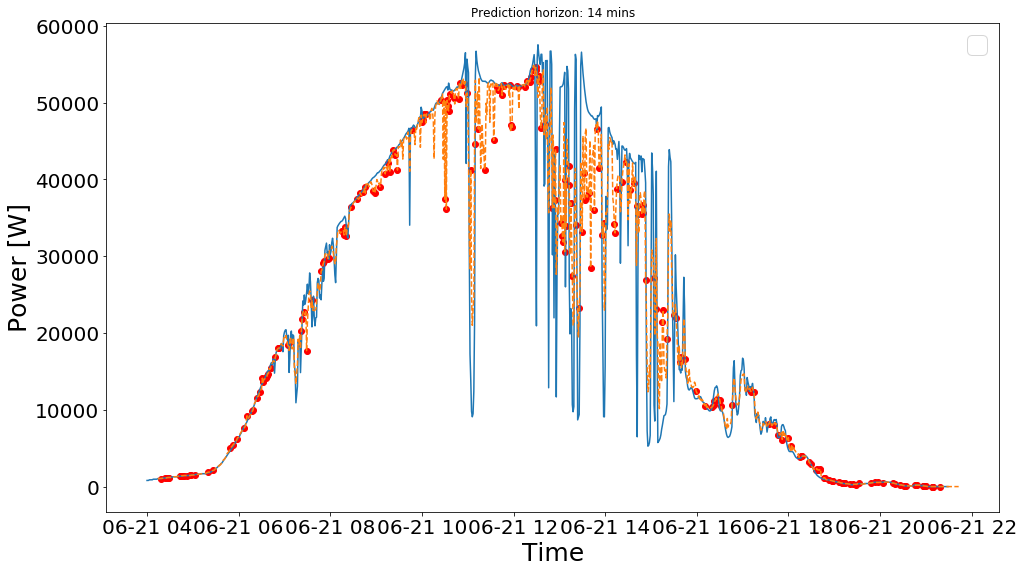

Mean Absolute Error: 2305.3999218497593
R2 score: 0.9204925116426593
Mean Squared Error: 27600647.513724368
Root Mean Squared Error: 5253.631840329542
Normalized RMSE: 0.12590344787123048
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.4 seconds to finish.


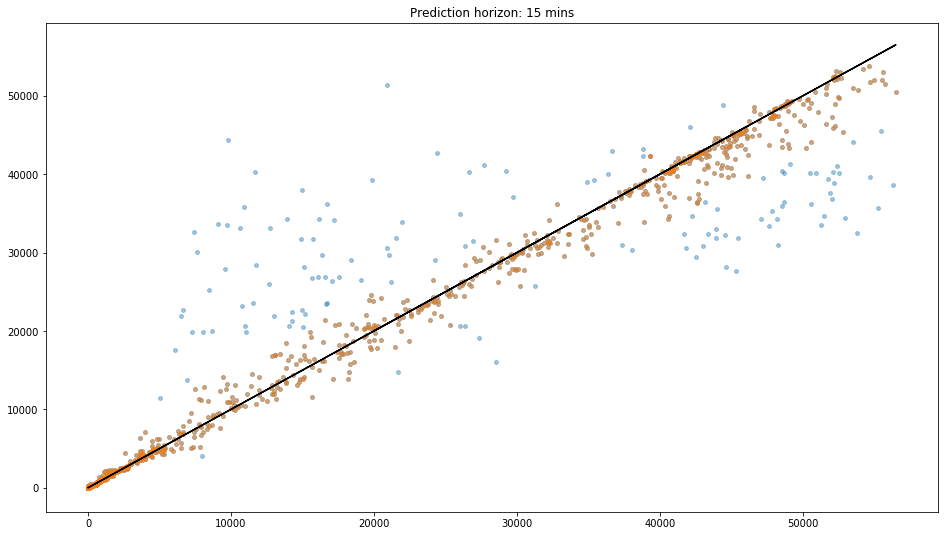

No handles with labels found to put in legend.


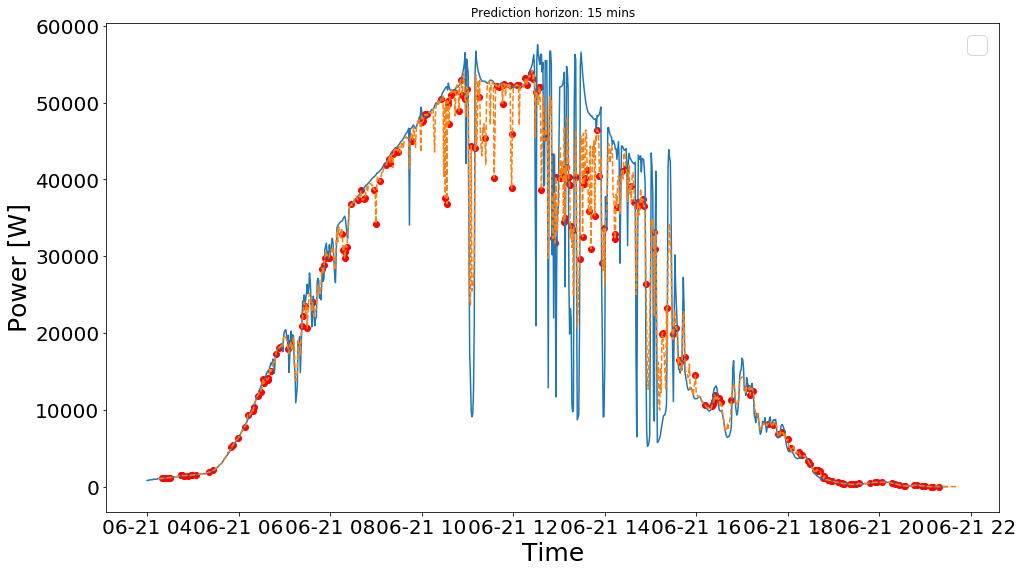

Mean Absolute Error: 2228.3208300551323
R2 score: 0.9290756570567117
Mean Squared Error: 24654127.98064701
Root Mean Squared Error: 4965.2923358697635
Normalized RMSE: 0.11845288352617941
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


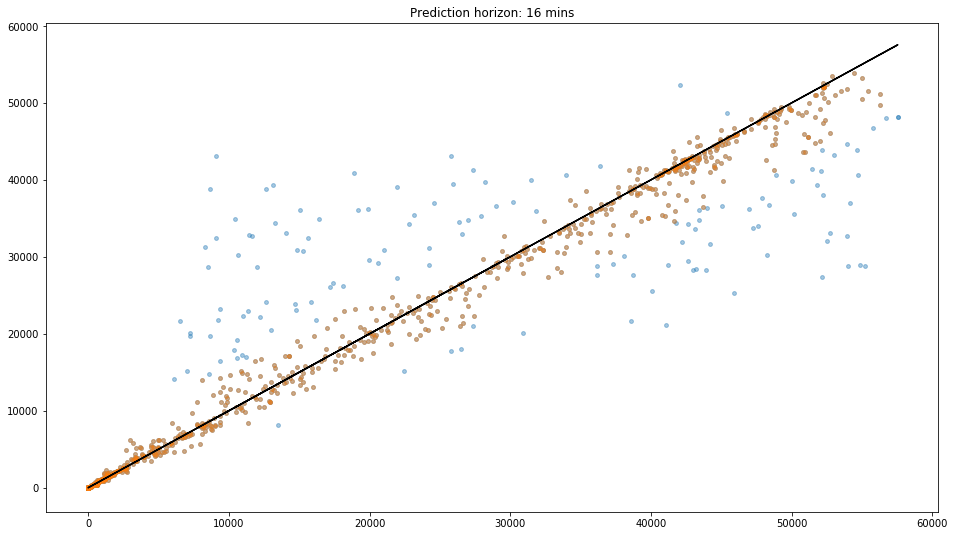

No handles with labels found to put in legend.


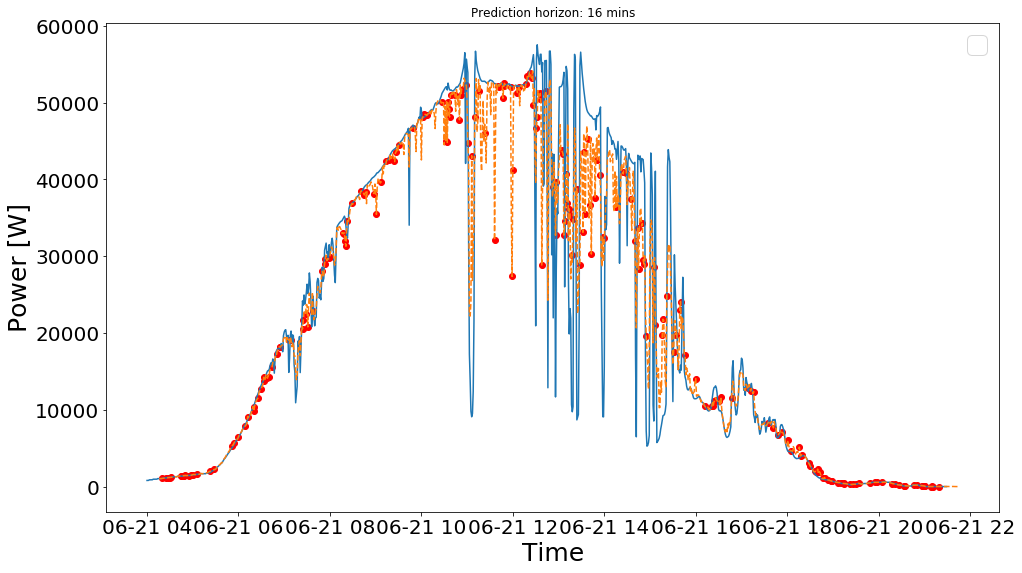

Mean Absolute Error: 2381.4637342715873
R2 score: 0.9200300211981499
Mean Squared Error: 27477016.266035367
Root Mean Squared Error: 5241.852369729175
Normalized RMSE: 0.12704441031820587
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.44 seconds to finish.


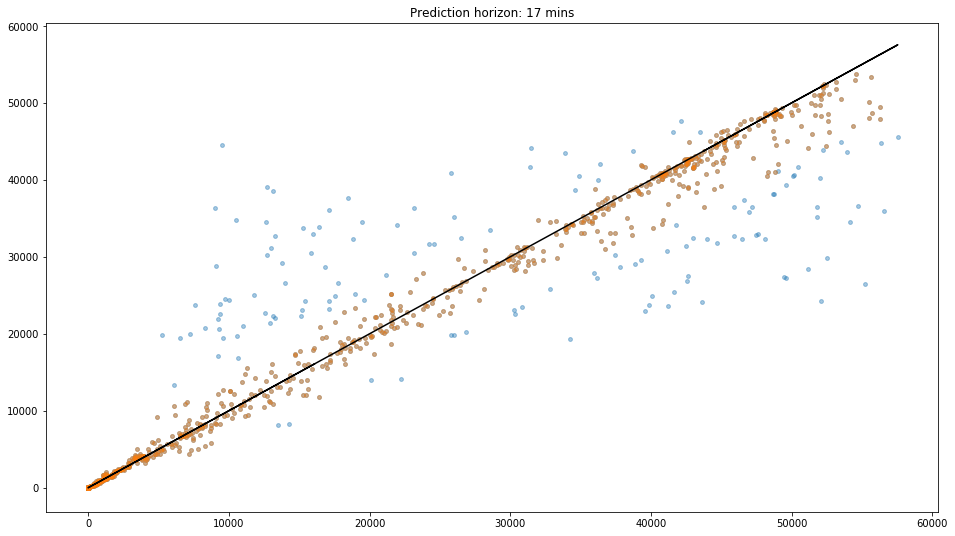

No handles with labels found to put in legend.


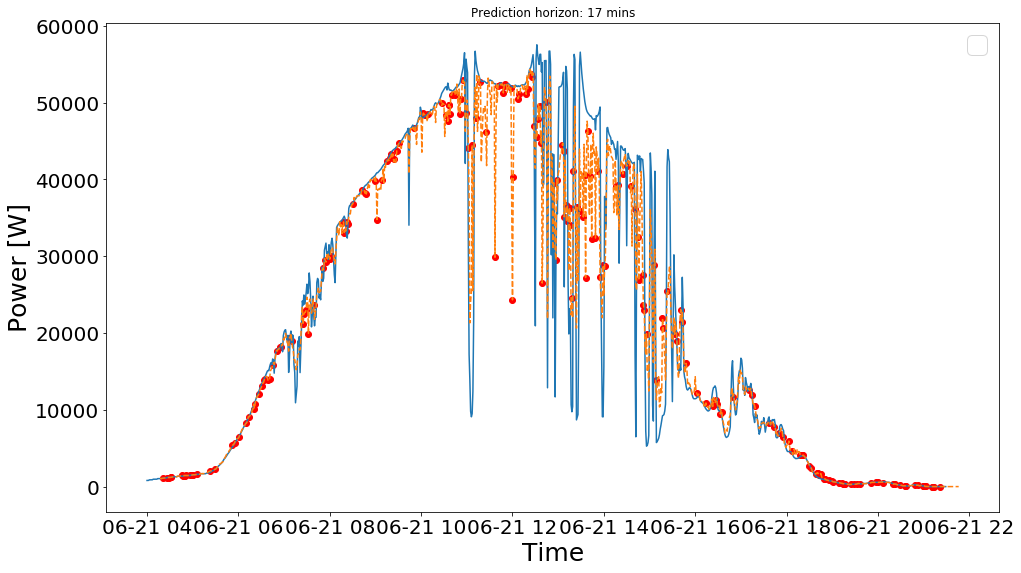

Mean Absolute Error: 2341.224811062984
R2 score: 0.9227052994360792
Mean Squared Error: 26718203.764163677
Root Mean Squared Error: 5168.965444280284
Normalized RMSE: 0.1259101740310024
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.39 seconds to finish.


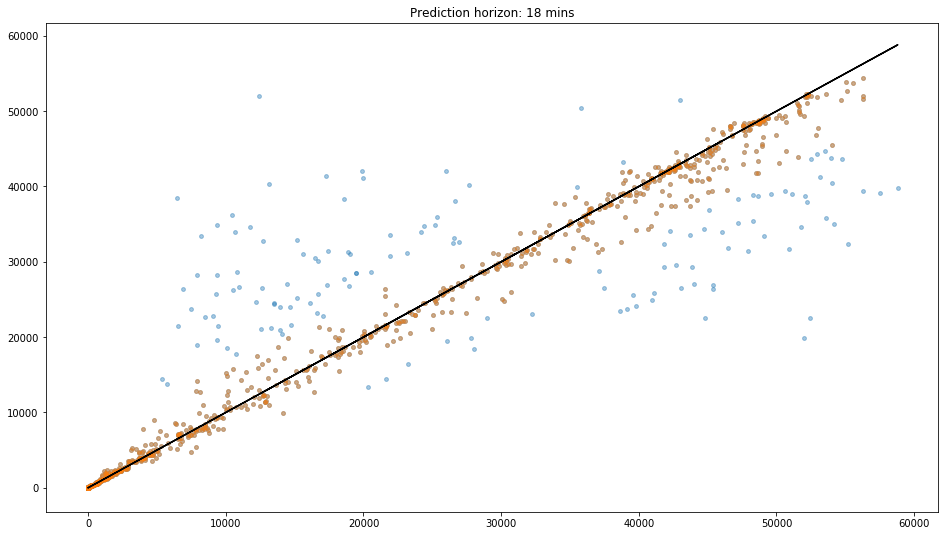

No handles with labels found to put in legend.


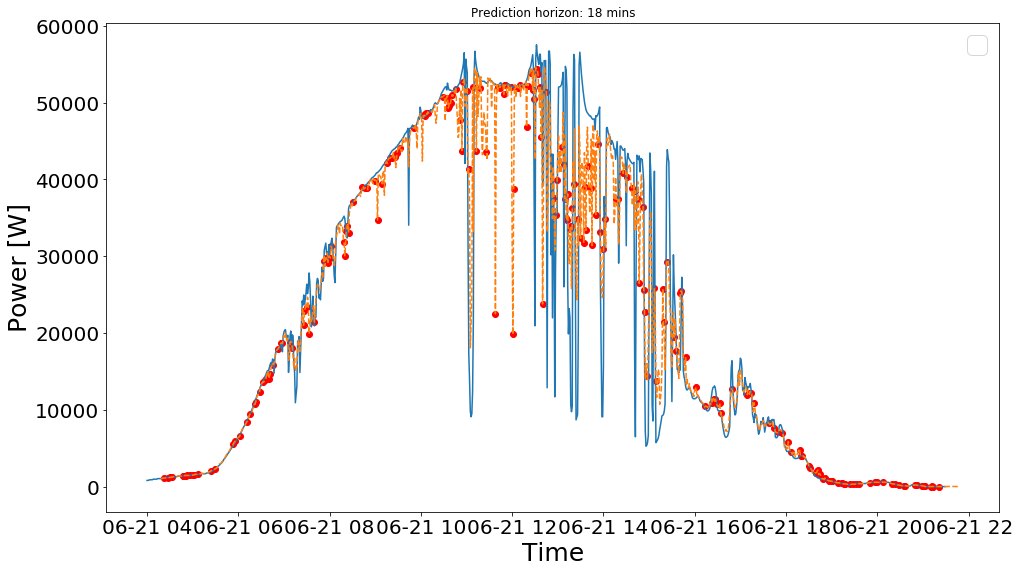

Mean Absolute Error: 2491.1238564105965
R2 score: 0.9109680444678755
Mean Squared Error: 30994401.19311514
Root Mean Squared Error: 5567.261552425496
Normalized RMSE: 0.1341922637353441
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.37 seconds to finish.


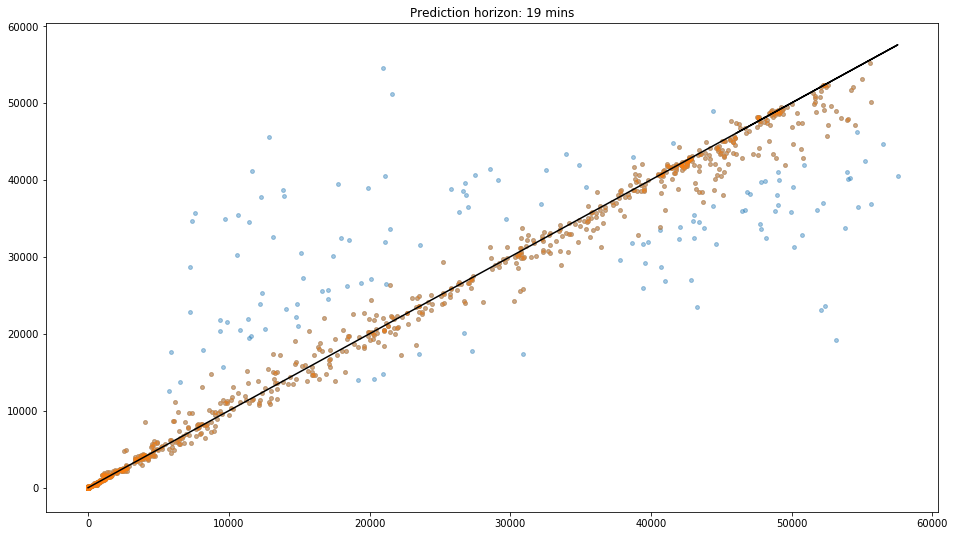

No handles with labels found to put in legend.


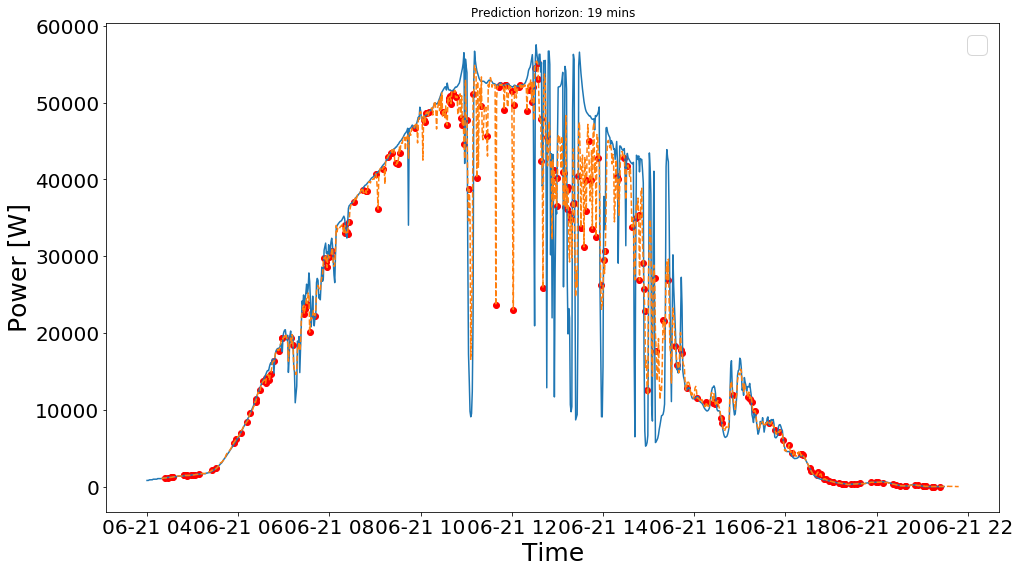

Mean Absolute Error: 2342.660243746281
R2 score: 0.9165506210252832
Mean Squared Error: 28840314.78717481
Root Mean Squared Error: 5370.317940976568
Normalized RMSE: 0.12937033095251174
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


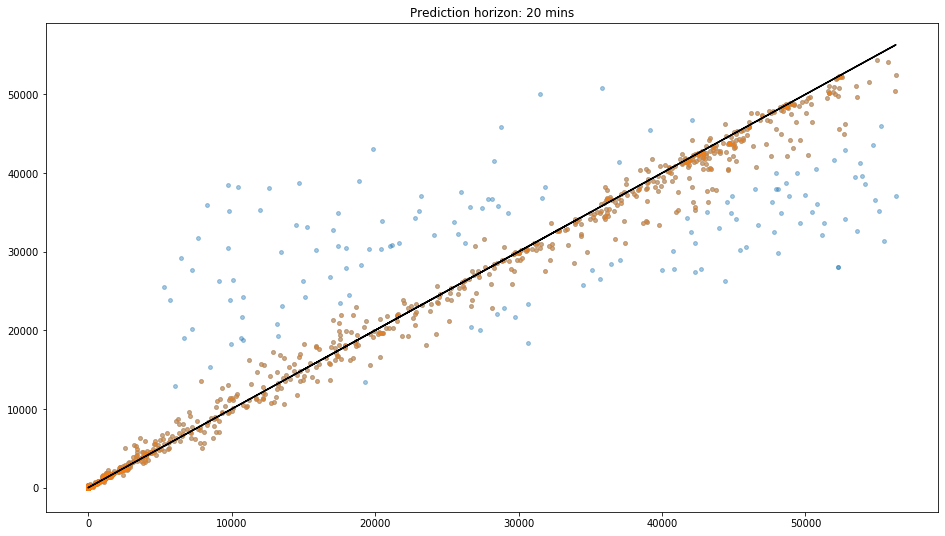

No handles with labels found to put in legend.


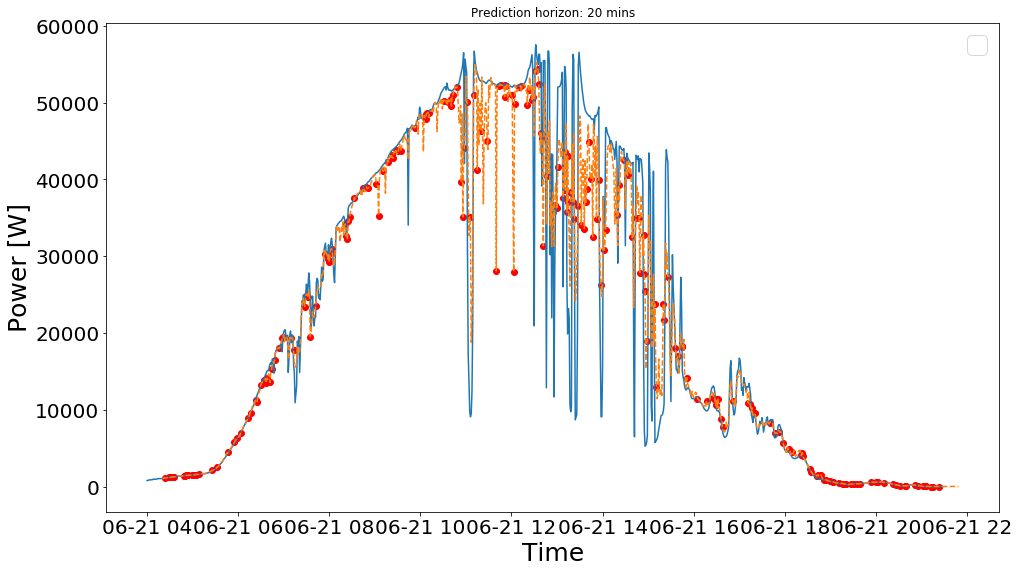

Mean Absolute Error: 2449.9460449745734
R2 score: 0.9169223383188153
Mean Squared Error: 28403279.774228394
Root Mean Squared Error: 5329.472748239585
Normalized RMSE: 0.12908458706501602
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.37 seconds to finish.


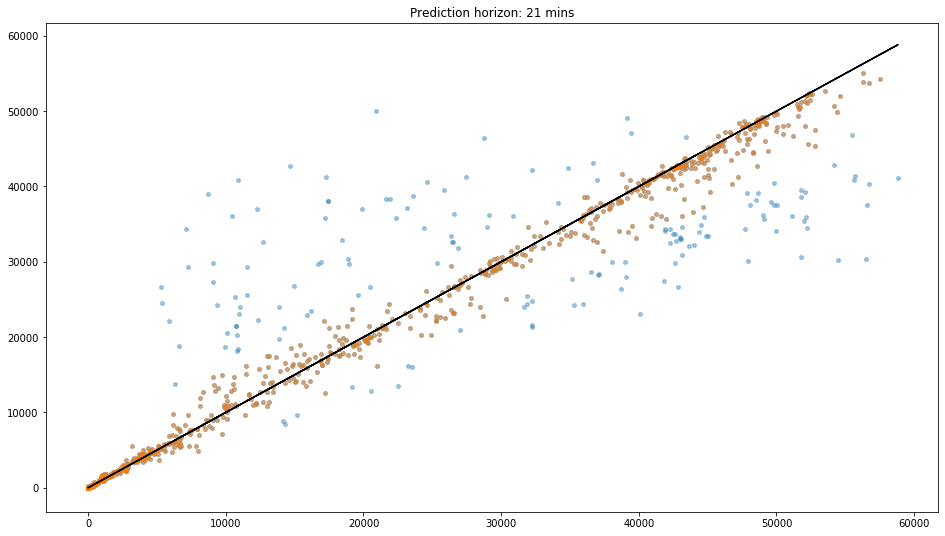

No handles with labels found to put in legend.


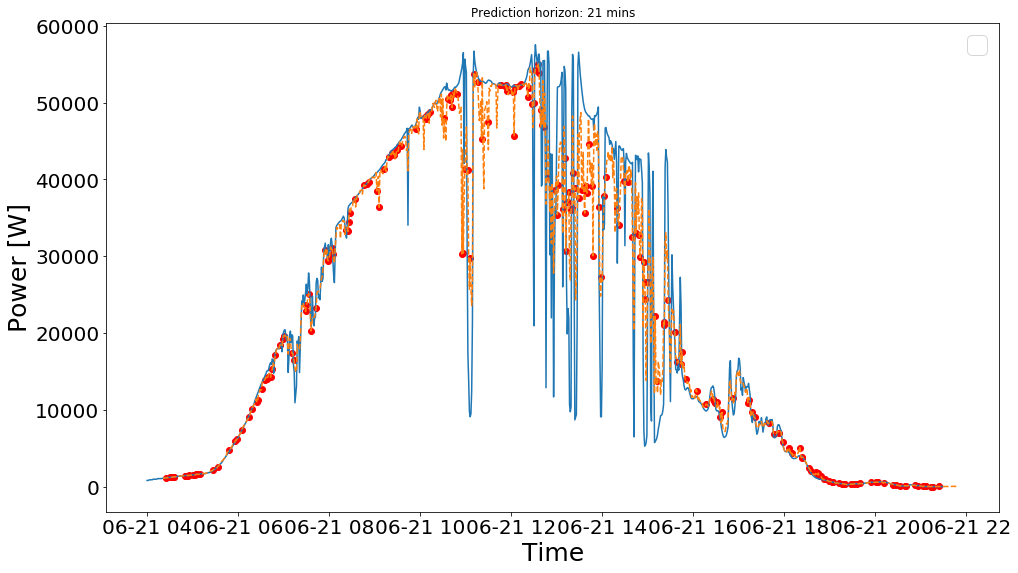

Mean Absolute Error: 2514.2108404439914
R2 score: 0.9156252532385416
Mean Squared Error: 29082706.444700785
Root Mean Squared Error: 5392.838440441247
Normalized RMSE: 0.12948861343533347
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.36 seconds to finish.


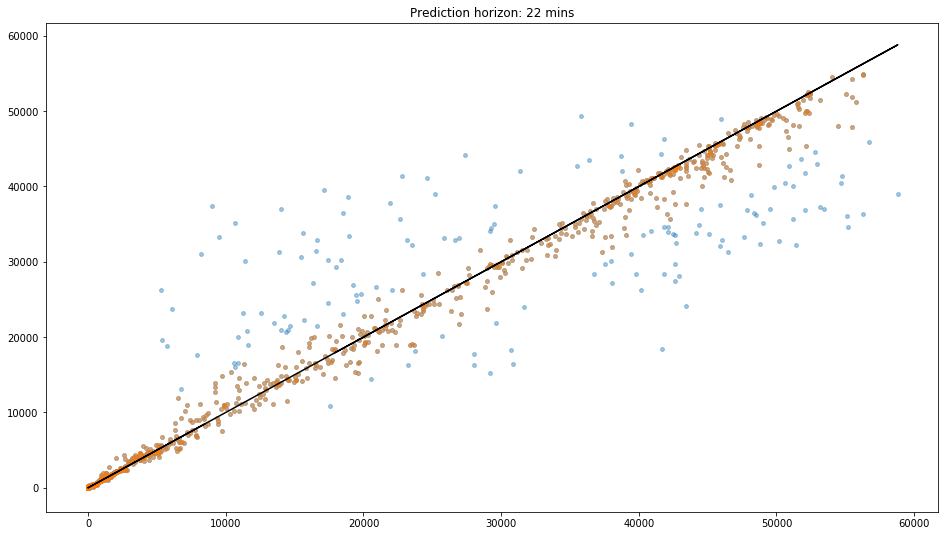

No handles with labels found to put in legend.


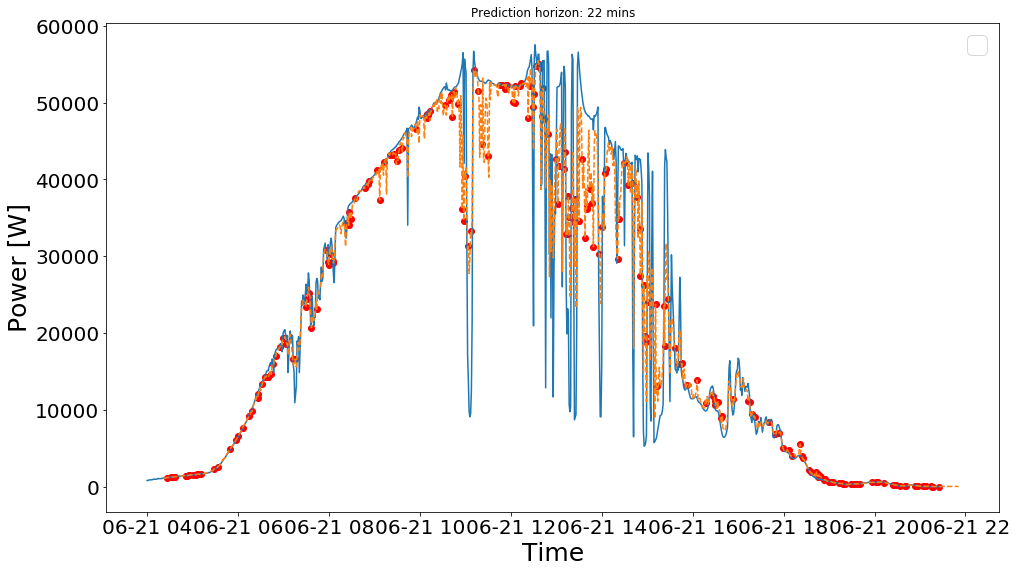

Mean Absolute Error: 2241.861809625812
R2 score: 0.9315863288712114
Mean Squared Error: 23526574.223189183
Root Mean Squared Error: 4850.42000482321
Normalized RMSE: 0.11791868459904334
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


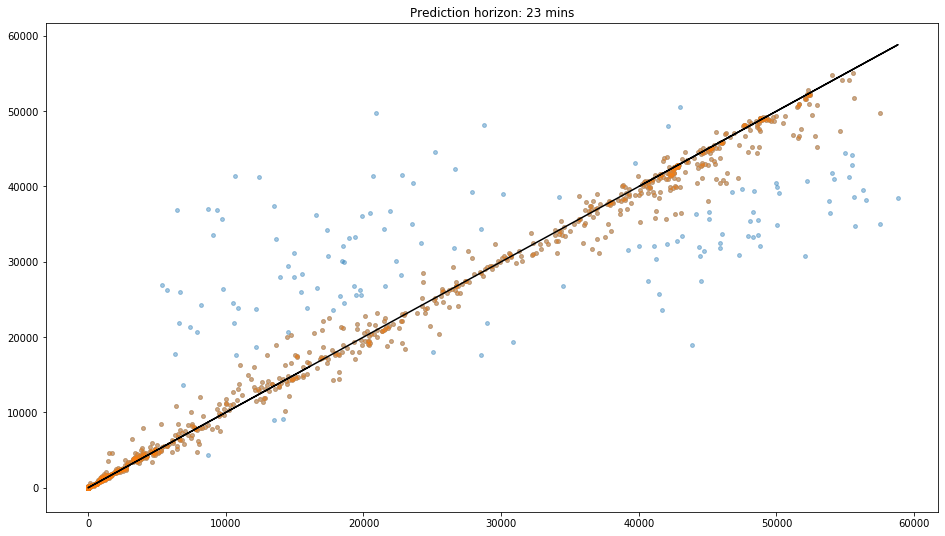

No handles with labels found to put in legend.


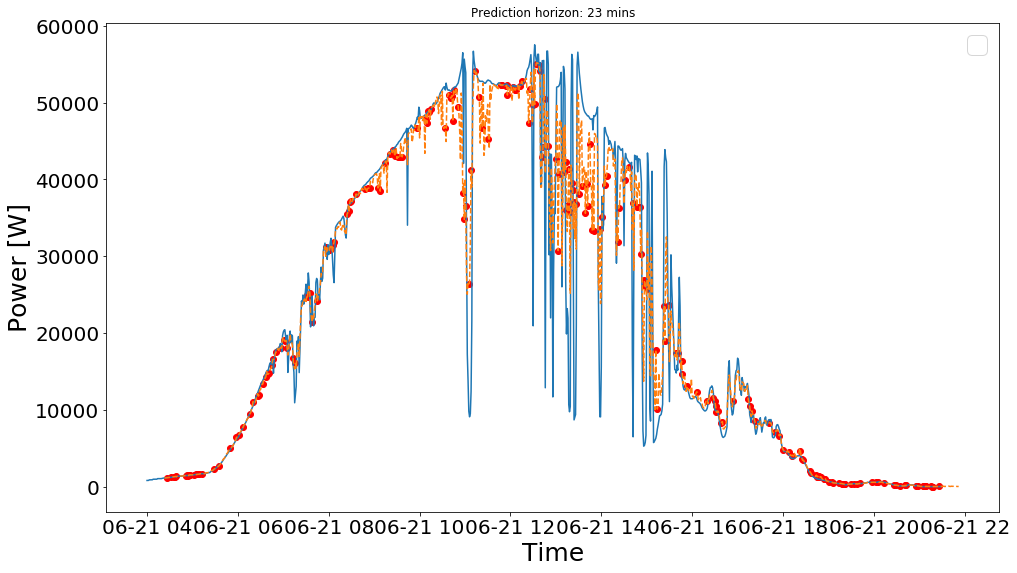

Mean Absolute Error: 2372.9481340033644
R2 score: 0.9154026032602136
Mean Squared Error: 29089732.09436934
Root Mean Squared Error: 5393.489788102815
Normalized RMSE: 0.13062840405532788
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.34 seconds to finish.


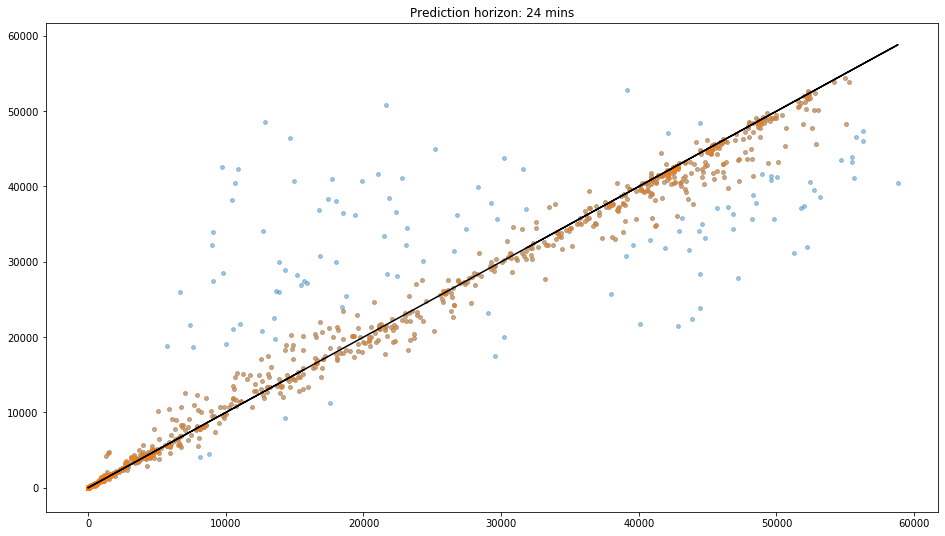

No handles with labels found to put in legend.


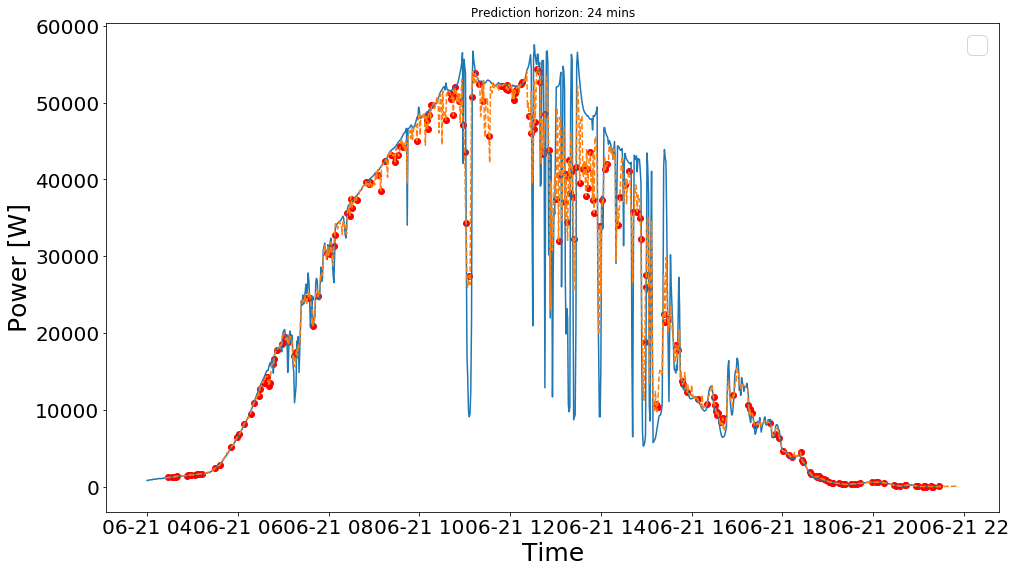

Mean Absolute Error: 2289.008917801898
R2 score: 0.9169031235177696
Mean Squared Error: 27996073.25116263
Root Mean Squared Error: 5291.131566230671
Normalized RMSE: 0.1286870705526813
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.34 seconds to finish.


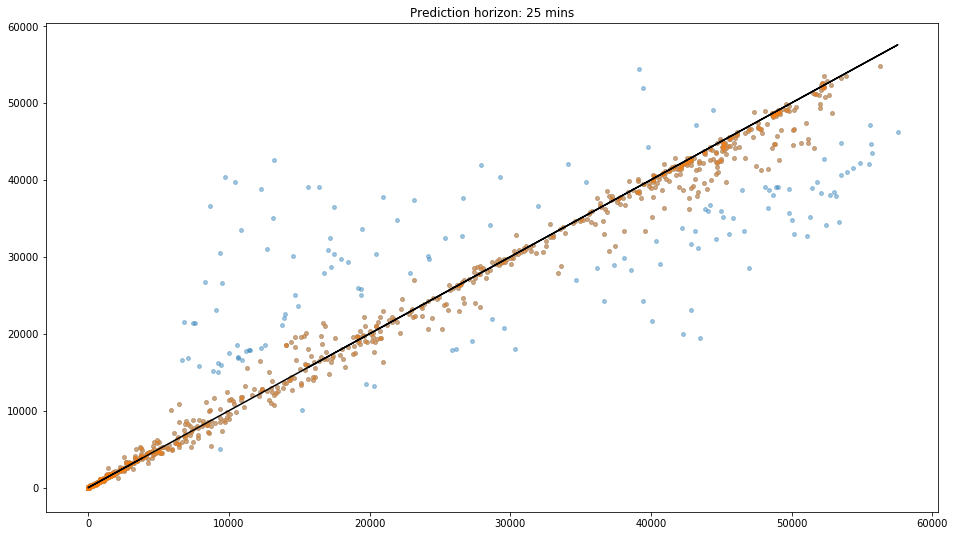

No handles with labels found to put in legend.


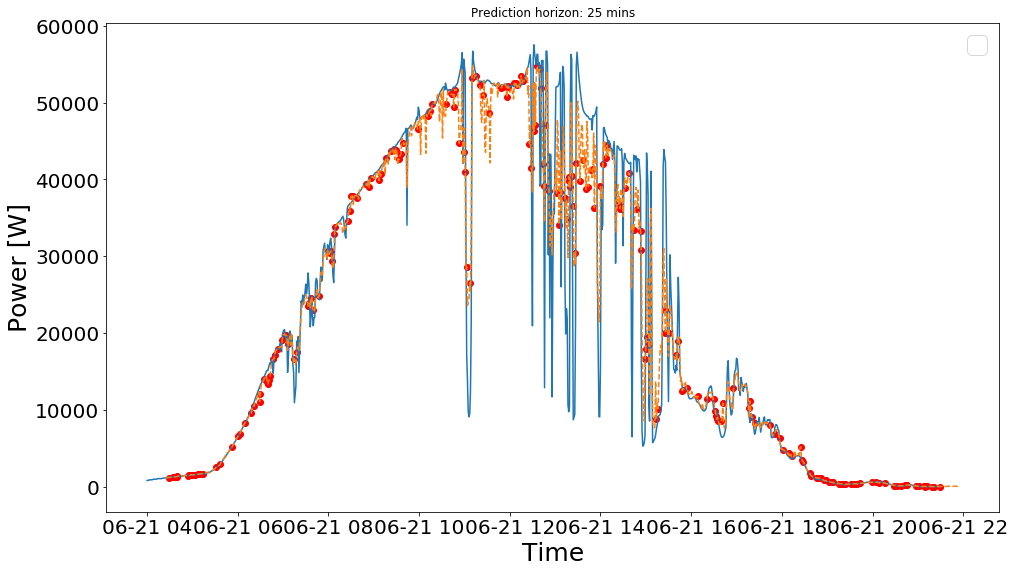

Mean Absolute Error: 2271.1151645141854
R2 score: 0.9270506861811961
Mean Squared Error: 25126913.50179169
Root Mean Squared Error: 5012.675283896982
Normalized RMSE: 0.12048001317643481
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.34 seconds to finish.


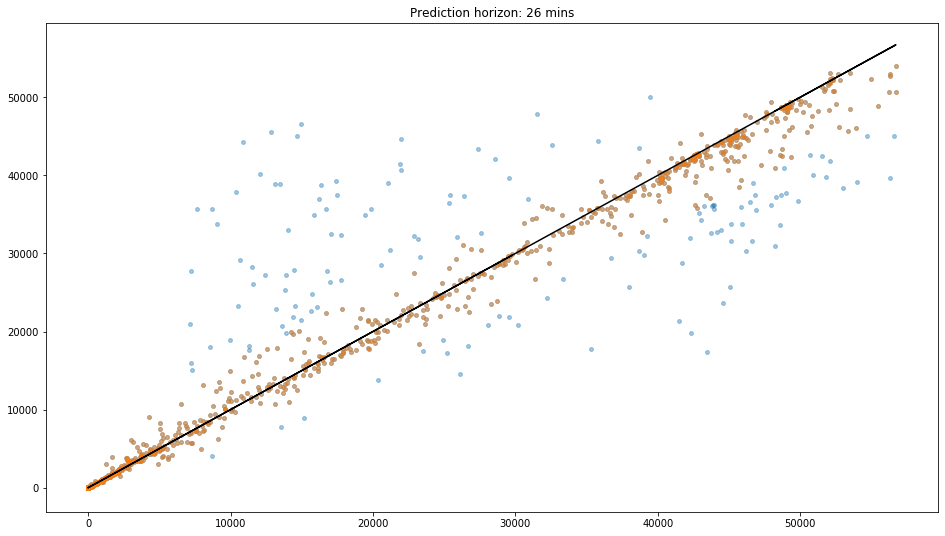

No handles with labels found to put in legend.


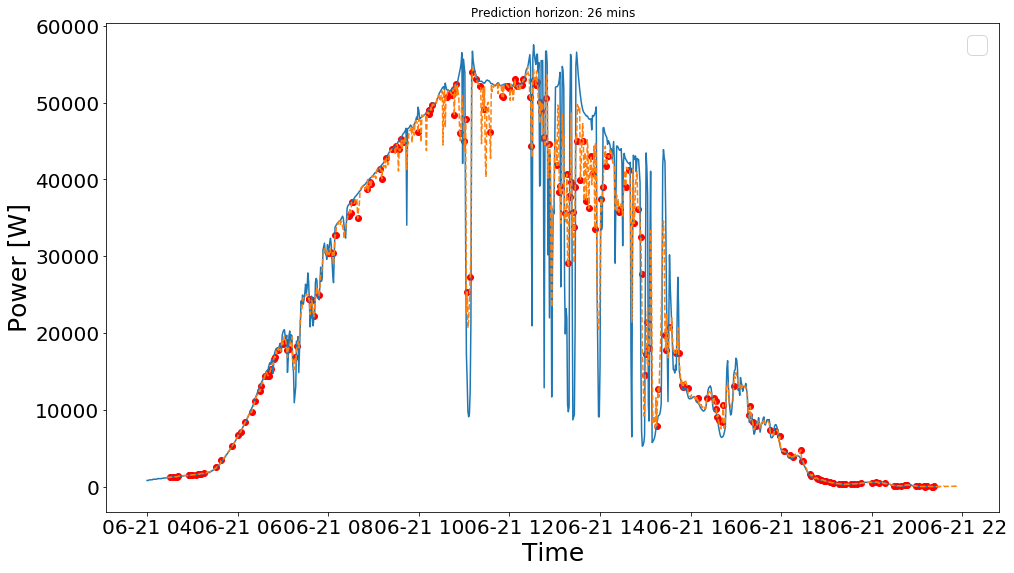

Mean Absolute Error: 2502.575540561963
R2 score: 0.9100900686010263
Mean Squared Error: 30538731.201279655
Root Mean Squared Error: 5526.185954279828
Normalized RMSE: 0.13297484002119797
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.35 seconds to finish.


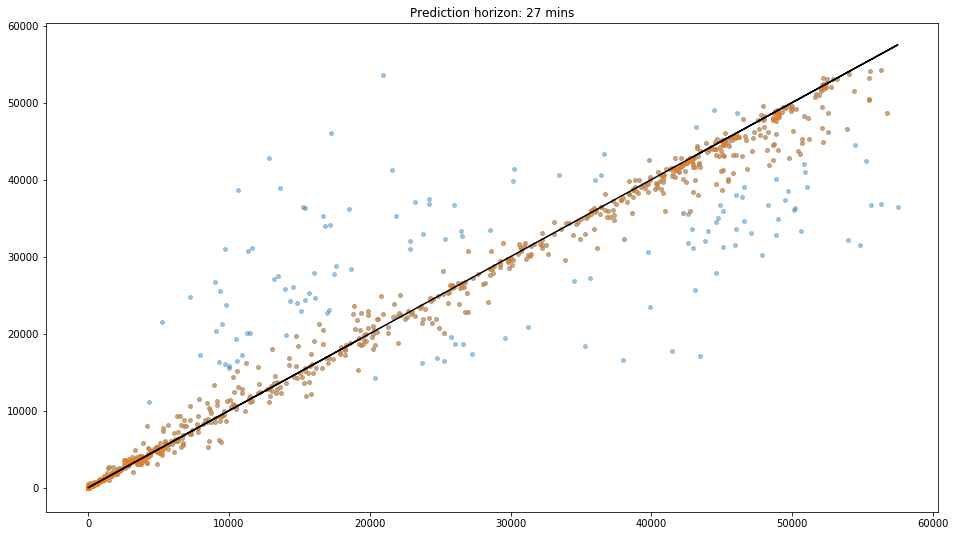

No handles with labels found to put in legend.


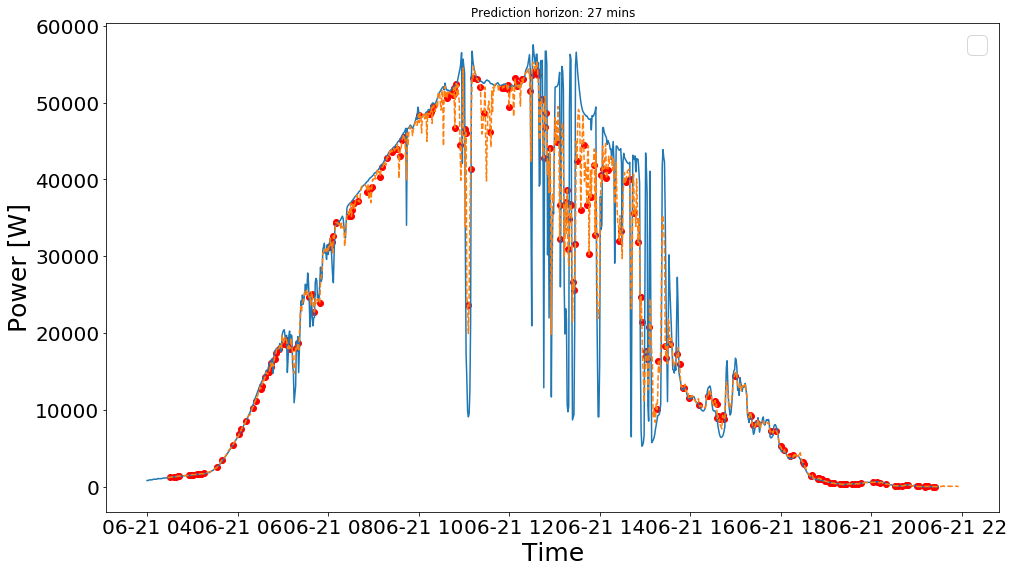

Mean Absolute Error: 2263.9826004465567
R2 score: 0.9264737299601846
Mean Squared Error: 25416276.294411436
Root Mean Squared Error: 5041.455771343376
Normalized RMSE: 0.12087114711820846
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.37 seconds to finish.


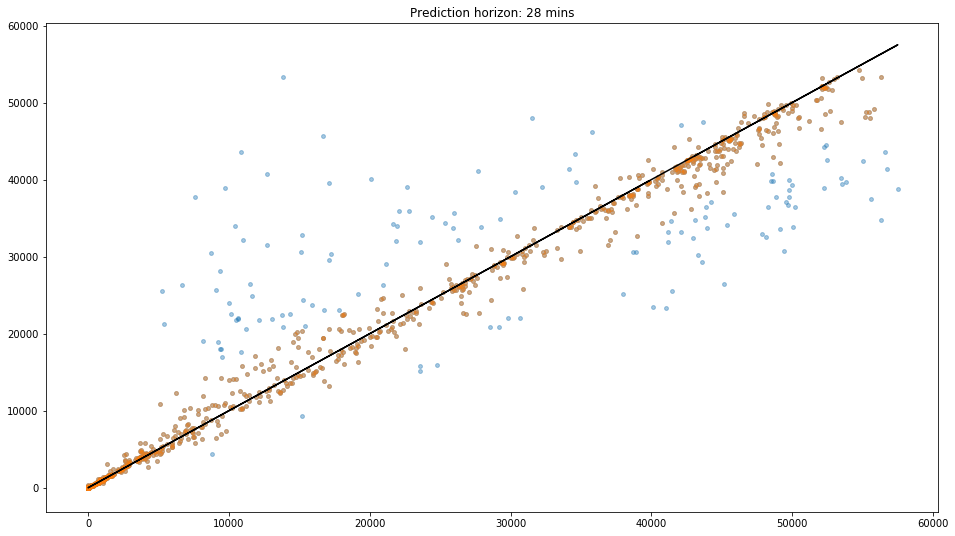

No handles with labels found to put in legend.


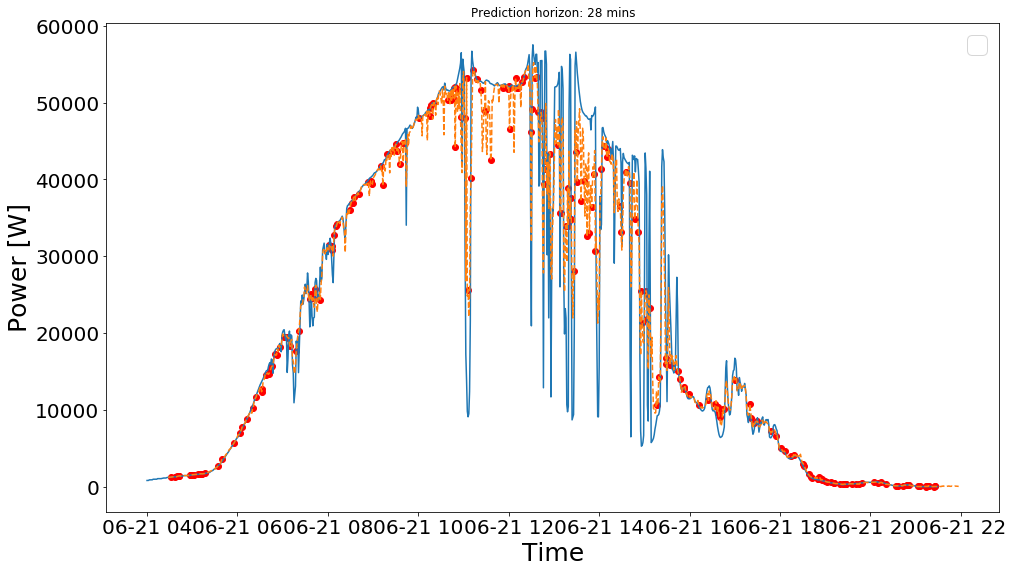

Mean Absolute Error: 2352.6637019633513
R2 score: 0.9225980971503105
Mean Squared Error: 26479381.666675277
Root Mean Squared Error: 5145.812051238879
Normalized RMSE: 0.1239540555254208
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


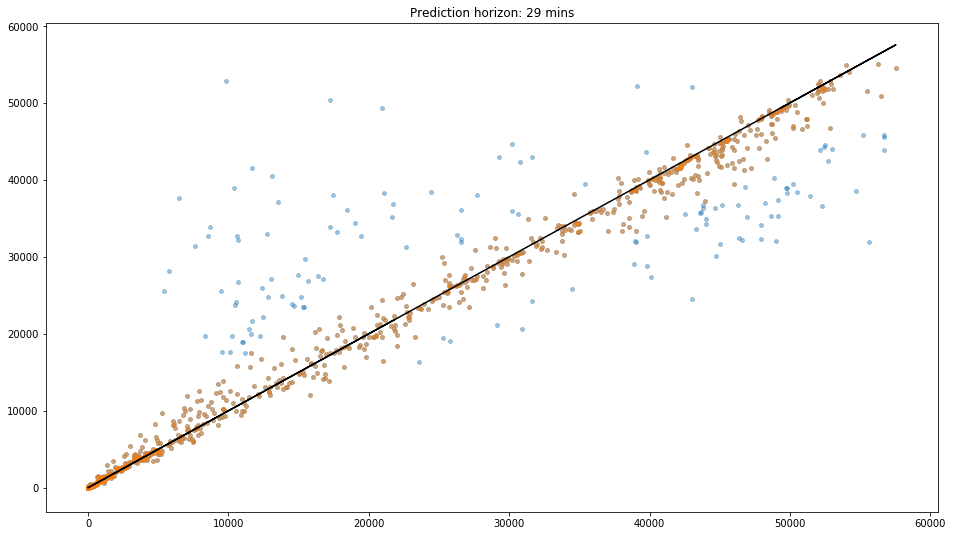

No handles with labels found to put in legend.


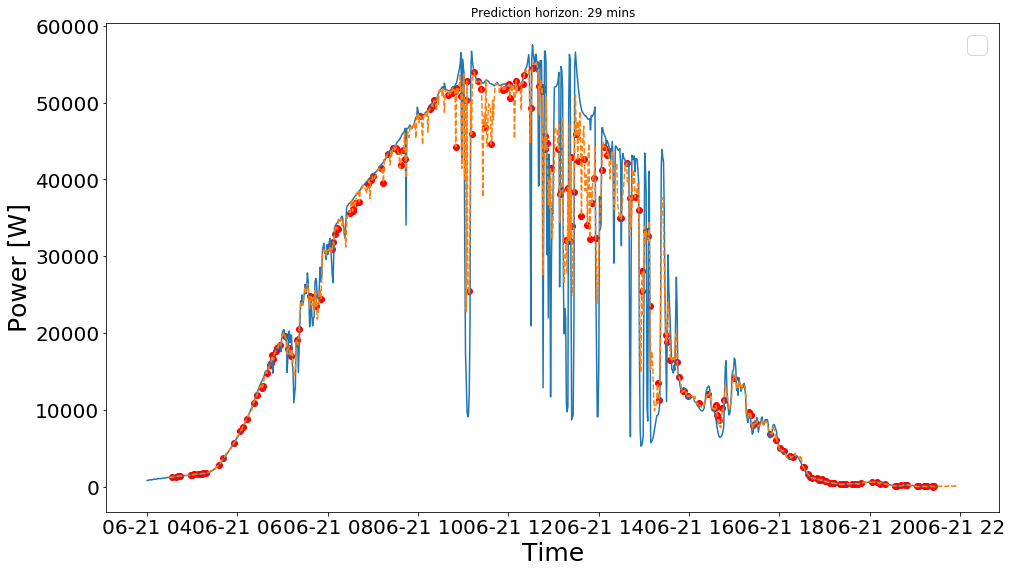

Mean Absolute Error: 2318.487740056493
R2 score: 0.9183459914572959
Mean Squared Error: 27552724.831284836
Root Mean Squared Error: 5249.068948993225
Normalized RMSE: 0.1283064685017312
 



C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:762: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_features_copy = df_features_copy[idx]
C:\Users\heinenr\Documents\git_local\twin_tools\twin_tools.py:763: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_targets_copy = df_targets_copy[idx]


Calculation done! It took 1.38 seconds to finish.


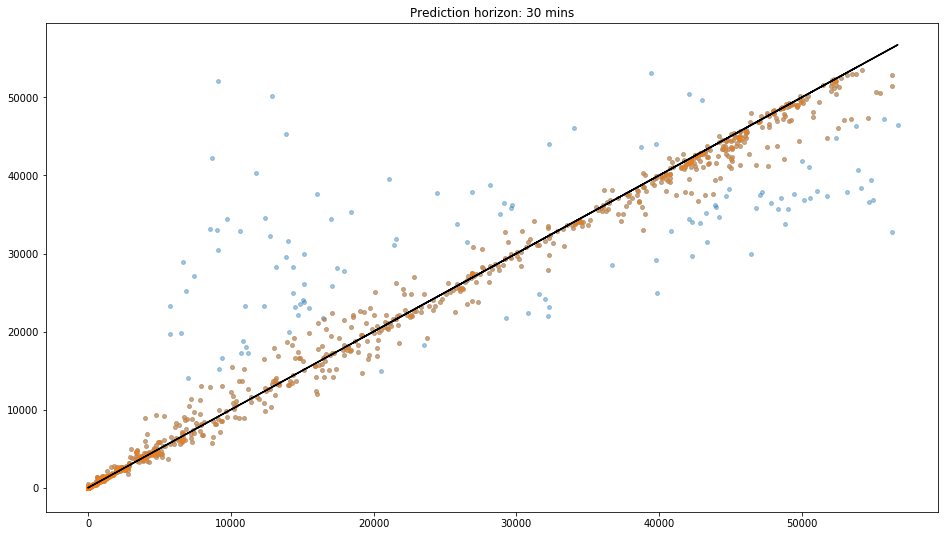

No handles with labels found to put in legend.


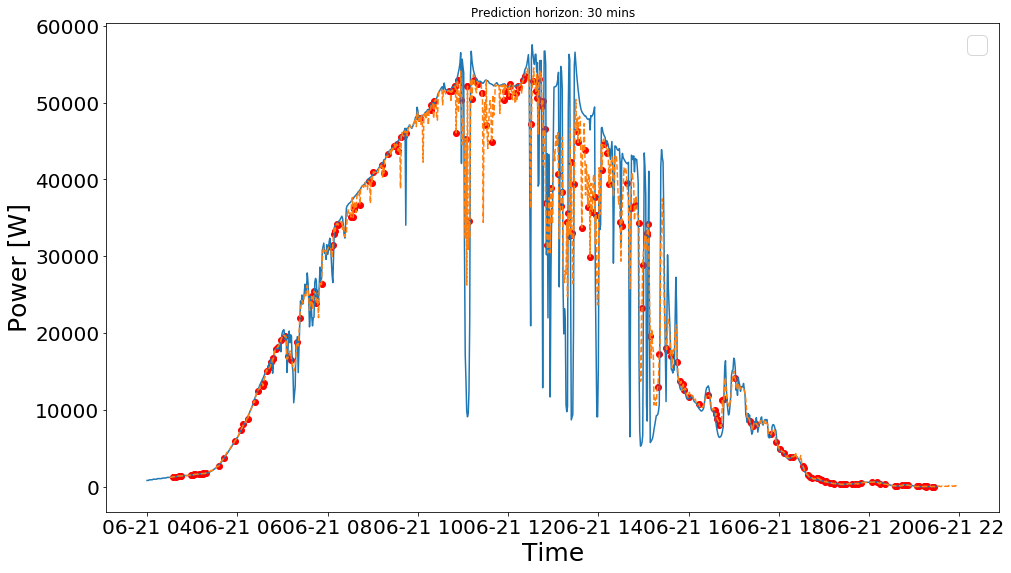

Mean Absolute Error: 2169.0375261032573
R2 score: 0.9257785234921257
Mean Squared Error: 25367276.436267957
Root Mean Squared Error: 5036.593733493695
Normalized RMSE: 0.12164509444023541
 



In [34]:
startdate = '2019-06-20'
enddate='2019-06-29'

regressor_dict = {}
for prediction_horizon in range(1,31):
    df_c_i = df_inverter.merge(all_predictions[prediction_horizon], how = 'inner', right_on=['date_time'], left_index=True)
    snow_index = df_c_i.index.tz_localize('UTC')
    snow = load_snowdata_apelsvoll(str(snow_index[0].date()), str(snow_index[-1].date()+pd.Timedelta(1,unit='D'))).resample('T').pad()[str(snow_index[0]):str(snow_index[-1])]
    snow = snow[~snow.index.duplicated()]
    snow.index = snow.index.tz_convert('UTC').tz_localize(None)
    df_c_i = df_c_i.join(snow, on=df_c_i.index)
    df_c_i = df_c_i[df_c_i['snow_depth']==0]
    df_c_i.drop(['swe', 'snow_depth'], axis=1, inplace=True)
    x = df_c_i.copy()

    
    x.index = x.index.shift(periods=prediction_horizon, freq='T')
    x = x[~x.index.duplicated()]

    y = df_c_i.copy()['ac_power']
    y = y[~y.index.duplicated()]
    
    model = 'forest'

    df_fit, y_test, regressor, features, nrmse = get_statistical_twin(x, y, model=model, return_fit=True, 
                                                       params_dict = {'bootstrap': True, 
                                                                      'max_features': 10, 
                                                                      'min_samples_leaf': 2, 
                                                                      'min_samples_split': 8, 
                                                                      'n_estimators': 93},
                                                 random_search=False, num_iteration_search=100, 
                                                            normalize_features=False, 
                                                           polynomial_degree=2)

    df_fit = pd.Series(df_fit)
    df_fit.index = y_test.index

    predictions = pd.DataFrame(regressor.predict(x[~x.isna().any(axis=1)]))
    predictions.index = x[~x.isna().any(axis=1)].index
    predictions.columns = ['Yr Predictions']
    
    
    regressor_dict[prediction_horizon] = regressor
    
    df_reduced = remove_outliers(y_test, df_fit, threshold=1)
    
    plt.figure(figsize=(16,9))
    plt.scatter(y_test, df_fit, s=15, alpha=0.4)
    plt.scatter(y_test, df_reduced, s=15, alpha=0.4)
    plt.plot(y_test, y_test, c='black')
    plt.title('Prediction horizon: '+str(prediction_horizon)+' mins')
    plt.show()


    plt.figure(figsize=(16,9))
    plt.plot(y[startdate:enddate], linestyle='-')
    plt.plot(predictions[startdate:enddate], linestyle='--')
    plt.scatter(df_fit.sort_index()[np.isfinite(df_fit.sort_index())][startdate:enddate].index, 
                df_fit.sort_index()[np.isfinite(df_fit.sort_index())][startdate:enddate], 
               c='r')
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Power [W]', fontsize=25)
    plt.legend(fontsize=25)
    plt.title('Prediction horizon: '+str(prediction_horizon)+' mins')
    plt.show()

    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, df_fit))
    print('R2 score:', metrics.r2_score(y_test, df_fit))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, df_fit))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, df_fit)))

    print('Normalized RMSE:', nrmse)
    print(' \n')
    
filename = 'apelsvoll_skycamera_predictions_regressors.sav'
pickle.dump(regressor_dict, open(filename, 'wb'))